# COMP 3610 Project

### A PREDICTIVE MODEL FOR ELECTORAL OUTCOMES IN TRINIDAD & TOBAGO USING MACROECONOMIC INDICATORS

- Christophe Gittens  
- Maia Neptune       
- Zidane Timothy     

In [473]:
# initialize Program
# %pip install requests beautifulsoup4 python-csv
# %pip install pandas

import pandas as pd
import numpy as np
import csv
import os
import requests
from bs4 import BeautifulSoup

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
csvs_path = "csvs"

# Loading the datasets

## Electoral Data

Electoral data was sourced from the [Elections and Boundaries Commission](https://ebctt.com) and collated into a single excel file and subsequently processed in the election_results.ipynb Jupyter notebook.

* Election data encompases the 41 constituinces that were redistricted in 2007


### Elections used in our predictive models -->

 - 2007
 - 2010
 - 2015
 - 2020

In [474]:
election_results = pd.read_excel('csvs/collated-tt-election-results.xlsx', sheet_name=['2007', '2010', '2015', '2020', '2025'], skiprows=[0,1,2,3,4])

# headers = 
# Access individual sheets using sheet names
sheet_1 = election_results['2007']
sheet_2 = election_results['2010']
sheet_3 = election_results['2015']
sheet_4 = election_results['2020']
sheet_5 = election_results['2025']  # blank sheet for 2025 with electorate data

In [475]:
sheet_1.to_csv('election2007.csv')

2015

Sourcing macroeconomic data from the World Bank API. 
We will examine the the impact of the following:
Trinidad and Tobago's Debt to GDP ratio.
Trinidad and Tobago's GDP.
Trinidad and Tobago's Inflation.
Trinidad and Tobago's Government Expenditure
Trinidad and Tobago's Unemployment Rate. 

### Debt to GDP
Source: [worldbank](api.worldbank.org) and the [CBTT](https://www.central-bank.org.tt/statistics/data-centre)

In [476]:
cols = ["Date", "Central Government Domestic Debt to GDP Ratio (%)",
        "Central Government External Debt to GDP Ratio (%)",
        "Central Government Total Debt to GDP Ratio (%)",
        "Contingent Liabilities Debt to GDP Ratio (%)",
        "Gross Public Sector Debt to GDP Ratio (%)", 
        "Net Public Sector Debt to GDP Ratio (%)"
        ]
df_debt_annual = pd.read_csv(r'csvs/Debt Annual  Central Bank of Trinidad and Tobago.csv',
                             usecols = cols, low_memory = True)
df_debt_annual

,Date,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%)
0,2024,40.1,19.3,59.4,n.d,n.d,n.d
1,2023,40.6,18.5,59.1,n.d,n.d,n.d
2,2022,41.5,18.3,59.8,n.d,n.d,n.d
3,2021,42.0,17.5,59.4,n.d,n.d,n.d
4,2020,44.0,20.0,64.0,20.6,83.9,76.7
5,2019,44.1,18.7,62.8,21.0,83.4,73.2
6,2018,42.9,16.4,59.3,18.4,77.0,61.3
7,2017,41.7,14.8,56.5,17.8,73.6,58.5
8,2016,42.2,13.4,55.6,19.0,74.7,54.9
9,2015,40.1,8.8,48.8,19.2,68.2,47.8


In [477]:
# url = 'https://api.worldbank.org/v2/country/TT/indicator/GC.XPN.TOTL.GD.ZS?format=json'
# response = requests.get(url)

# if response:
#     data = response.json()
#     tt_debt = data[1]
#     df = pd.DataFrame(tt_debt)
#     df.to_csv(os.path.join(csvs_path,r'tt_debt_to_gdp.csv'))

# else:
#     print("Response is not 200.")

### GDP
Source: [Worldbank](api.worldbank.org)

In [478]:


# url = 'https://api.worldbank.org/v2/country/TT/indicator/NY.GDP.MKTP.CD?format=json'
# response = requests.get(url)

# if response:
#     data = response.json()
#     tt_gdp = data[1]
#     df_gdp = pd.DataFrame(tt_gdp)
#     df_gdp.to_csv(os.path.join(csvs_path,r'tt_gdp.csv'))

# else:
#     print("Response is not 200.")

### Inflation
Source: [worldbank](api.worldbank.org) and the [CBTT](https://www.central-bank.org.tt/statistics/data-centre)

In [479]:
cols = ["Date", "Date",
        "Annual Average Percent Change in the Index of Retail Prices - Inflation Rate (%)",
        "Unemployment Rate (%)","WTI Crude Oil Price (US$/bbl)",
        "Henry Hub Natural Gas Price (US$/mmbtu)",
        "Net Official Reserves (US$Mn)"
        ]
df_inflation_annual = pd.read_csv(r'csvs/Selected Economic Indicators Annual  Central Bank of Trinidad and Tobago.csv',
                             usecols = cols, low_memory = True)

In [480]:
url = 'https://api.worldbank.org/v2/country/TT/indicator/FP.CPI.TOTL.ZG?format=json'
response = requests.get(url)

if response:
    data = response.json()
    tt_inflation = data[1]
    df_inflation = pd.DataFrame(tt_inflation)
    df_inflation.to_csv(os.path.join(csvs_path,r'tt_inflation.csv'))

else:
    print("Response is not 200 for inflation.")


### Unemployment rate
Source:  [worldbank](api.worldbank.org)

In [481]:
cols = ["Date", "Unemployment Rate (%)"
        ]
tt_unemployment = pd.read_csv(r'csvs/Selected Economic Indicators Annual  Central Bank of Trinidad and Tobago.csv',
                             usecols = cols, low_memory = True)

In [482]:
url = 'https://api.worldbank.org/v2/country/TT/indicator/SL.UEM.TOTL.ZS?format=json'
response = requests.get(url)

if response:
    data = response.json()
    tt_unemployment = data[1]
    df = pd.DataFrame(tt_unemployment)
    df.to_csv(os.path.join(csvs_path,r'tt_unemployment_rate.csv'))

else:
    print("Response is not 200.")

### Government expenditure

Source: [worldbank](api.worldbank.org) and [CBTT](https://www.central-bank.org.tt/statistics/data-centre)

In [483]:
df_expenditure = pd.read_csv("csvs/Public Finance Annual  Central Bank of Trinidad and Tobago.csv")

In [484]:
# url = 'https://api.worldbank.org/v2/country/TT/indicator/GC.XPN.TOTL.GD.ZS?format=json'
# response = requests.get(url)

# if response:
#     data = response.json()
#     tt_expenditure = data[1]
#     df_expenditure = pd.DataFrame(tt_expenditure)
#     df_expenditure.to_csv(os.path.join(csvs_path,r'tt_gov_expenditure.csv'))

# else:
#     print("Response is not 200.")

### Homicide rate
Source: Web-Scraping from [macrotrends](macrotrends.net)

In [485]:


# url ='https://www.macrotrends.net/global-metrics/countries/TTO/trinidad-and-tobago/murder-homicide-rate'

# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
# }

# response = requests.get(url, headers=headers)

# if response:
#     soup = BeautifulSoup(response.content, 'html.parser')

#     div = soup.find('div', {'class': 'col-xs-6'})
#     crime_data =[]
#     if div:
#         table = div.find_all('table', {'class':'historical_data_table table table-striped table-bordered'})
#         table = table[0]
#     if table:
#         for row in table.find_all('tr')[2:]:
#             cells = row.find_all('td')
#             if len(cells) == 3:
#                 year = cells[0].get_text(strip=True)
#                 rate_per_100k = cells[1].get_text(strip=True)
#                 annual_change = cells[2].get_text(strip=True)
#                 crime_data.append([year,rate_per_100k,annual_change])

#         df_homicide_rate = pd.DataFrame(crime_data, columns=['Year','Rate_per_100k_Population','Annual_change'])

#         df_homicide_rate.to_csv(os.path.join(csvs_path,r'tt_homicide_rate.csv'), index=False)
# else:
#     print('Response is not 200.')

### Migration Rates
Source: Web-Scraping from [macrotrends](macrotrends.net)

In [486]:


# url = "https://www.macrotrends.net/global-metrics/countries/TTO/trinidad-and-tobago/net-migration#:~:text=The%20net%20migration%20rate%20for,a%200.35%25%20decline%20from%202022."
# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
# }

# response = requests.get(url, headers=headers)

# if response.status_code == 200:
#     soup = BeautifulSoup(response.text, "html.parser")
#     # print(soup.prettify())  # Check page structure
# else:
#     print("Failed to fetch page:", response.status_code)

# tables = soup.find_all("table")

# # ensure there are at least 2 tables before accessing the second one
# if len(tables) >= 2:
#     second_table = tables[1]  # Get the second table
#     df_migration_rate = pd.read_html(str(second_table))[0]
#     df_migration_rate.columns = ["Year", "Net Migration Rate", "Growth Rate"]
#     print(df_migration_rate)
# else:
#     print("Second table not found!")

# df_migration_rate.to_csv(os.path.join(csvs_path, r'tt_migration_rate.csv'), index=False)


### Currency Exchange Rate
Source: [CBTT](https://www.central-bank.org.tt/statistics/data-centre)

In [487]:
df_exchange_rate = pd.read_csv("csvs/Exchange Rates Annual  Central Bank of Trinidad and Tobago (1).csv")
df_exchange_rate

,Date,Yen Buying,Yen Selling,US Buying,US Selling,Barbados Buying Rate,Barbados Selling Rate,Canadian Buying Rate,Canadian Selling Rate,Swiss Franc Buying Rate,Swiss Franc Selling Rate,EC Buying,EC Selling,Euro Buying,Euro Selling,Pound Buying,Pound Selling,Guyanese Buying,Guyanese Selling
0,2020,0.0630,0.0666,6.7204,6.7803,3.0145,3.5265,5.0261,5.3627,7.1418,7.4692,2.4017,2.6083,7.7617,8.2307,8.6183,9.2182,0.0308,0.0320
1,2019,0.0617,0.0653,6.7306,6.7800,2.9722,3.5199,5.0538,5.3813,6.6645,7.0753,2.4026,2.6062,7.5445,8.0224,8.5342,9.1294,0.0310,0.0321
2,2018,0.0609,0.0642,6.7321,6.7813,3.0253,3.5200,5.1438,5.4918,6.7467,7.2125,2.4105,2.6081,7.9261,8.4500,8.9231,9.5572,0.0311,0.0323
3,2017,0.0599,0.0628,6.7283,6.7795,3.2014,3.5195,5.1182,5.4517,6.6230,7.1055,2.4061,2.6132,7.5373,8.0093,8.6071,9.1537,0.0314,0.0326
4,2016,0.0632,0.0642,6.6152,6.6715,3.1694,3.4586,4.9425,5.2478,6.5403,6.9633,2.3779,2.5788,7.2682,7.6602,8.8462,9.4051,0.0314,0.0327
5,2015,0.0522,0.0546,6.3298,6.3776,3.0357,3.2837,4.8932,5.1793,6.4836,6.8578,2.2653,2.4485,6.9171,7.3032,9.5120,10.0569,0.0301,0.0312
6,2014,0.0602,0.0607,6.3613,6.4086,2.7995,3.2776,5.6779,5.9750,6.7732,7.2603,2.2761,2.4384,8.2714,8.6831,10.2525,10.7882,0.0303,0.0314
7,2013,0.0656,0.0662,6.3885,6.4426,2.7352,3.2935,6.1134,6.4166,6.7316,7.1737,2.2886,2.4468,8.2916,8.6617,9.7838,10.2313,0.0306,0.0329
8,2012,0.0799,0.0807,6.3716,6.4349,2.7123,3.2917,6.2971,6.5787,6.6408,7.0760,2.2977,2.4425,8.0181,8.3414,9.8817,10.3595,0.0306,0.0319
9,2011,0.0800,0.0807,6.3731,6.4261,2.7422,3.2816,6.3605,6.6262,7.1226,7.4970,2.2925,2.4321,8.6736,9.0375,9.9974,10.4562,0.0308,0.0320


# Preprocessing

From the central bank website n.d. is No Data or NA so that is taken in consideration moving forward. 

#### Preprocessing of electoral data

In [488]:
sheet_1

,Unnamed: 0,Unnamed: 1,VOTES CAST,Unnamed: 3,Unnamed: 4,POLLED,VOTES,%,VOTES.1,%.1,VOTES.2,%.2,VOTES.3,%.3,VOTES.4,%.4,VOTES.5,%.5
0,ARIMA,22845,13464,0.589363,91,13373,8603,0.643311,1224,0.091528,3464,0.259029,NaN,NaN,NaN,NaN,82.0,0.006132
1,AROUCA/MALONEY,23673,15948,0.673679,40,15908,12055,0.757795,1480,0.093035,2373,0.149170,NaN,NaN,NaN,NaN,NaN,NaN
2,BARATARIA/SAN JUAN,24597,16451,0.668821,93,16358,7179,0.438868,5362,0.327791,3817,0.233341,NaN,NaN,NaN,NaN,NaN,NaN
3,CARONI CENTRAL,22813,16640,0.729409,46,16594,4579,0.275943,7615,0.458901,4400,0.265156,NaN,NaN,NaN,NaN,NaN,NaN
4,CARONI EAST,23554,16460,0.698820,64,16396,3833,0.233777,8333,0.508234,4230,0.257990,NaN,NaN,NaN,NaN,NaN,NaN
5,CHAGUANAS EAST,22383,15887,0.709780,51,15836,6757,0.426686,4993,0.315294,4086,0.258020,NaN,NaN,NaN,NaN,NaN,NaN
6,CHAGUANAS WEST,24272,18029,0.742790,82,17947,1519,0.084638,11150,0.621274,5278,0.294088,NaN,NaN,NaN,NaN,NaN,NaN
7,COUVA NORTH,25898,18992,0.733338,72,18920,5249,0.277431,8832,0.466808,4839,0.255761,NaN,NaN,NaN,NaN,NaN,NaN
8,COUVA SOUTH,25188,17987,0.714110,53,17934,5097,0.284209,8428,0.469945,4409,0.245846,NaN,NaN,NaN,NaN,NaN,NaN
9,CUMUTO/MANZANILLA,24700,17751,0.718664,76,17675,7124,0.403055,7368,0.416860,3183,0.180085,NaN,NaN,NaN,NaN,NaN,NaN


In [489]:
sheet_1.isna().sum()

Unnamed: 0     0
Unnamed: 1     0
VOTES CAST     0
Unnamed: 3     0
Unnamed: 4     0
POLLED         0
VOTES          0
%              0
VOTES.1        0
%.1            0
VOTES.2        0
%.2            0
VOTES.3       39
%.3           39
VOTES.4       39
%.4           39
VOTES.5       37
%.5           37
dtype: int64

In [490]:
# sht_07, sht_10, sht_15, sht_20 = sheet_2007.iloc[3:], sheet_2010.iloc[3:], sheet_2015.iloc[3:], sheet_2020.iloc[3:]

# print(sht_07)
# print(sht_10)
# print(sht_15)
# print(sht_20)
# sht_20

In [491]:
sheet_1.shape

(42, 18)

Fixing headers

### 2007 Parliamentary Election

In [492]:
cols= [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%', 'C.O.P._VOTES', 
            'C.O.P._VOTES_%', 'D.A.C._VOTES', 'D.A.C._VOTES_%', 'D.N.A._VOTES', 
            'D.N.A._VOTES_%', 'I.N.D_VOTES', 'I.N.D._VOTES_%'
        ]
sht_07 = sheet_1
sht_07.columns = cols
sht_07.fillna(0, inplace=True)
sht_07

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,C.O.P._VOTES,C.O.P._VOTES_%,D.A.C._VOTES,D.A.C._VOTES_%,D.N.A._VOTES,D.N.A._VOTES_%,I.N.D_VOTES,I.N.D._VOTES_%
0,ARIMA,22845,13464,0.589363,91,13373,8603,0.643311,1224,0.091528,3464,0.259029,0.0,0.000000,0.0,0.000000,82.0,0.006132
1,AROUCA/MALONEY,23673,15948,0.673679,40,15908,12055,0.757795,1480,0.093035,2373,0.149170,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,BARATARIA/SAN JUAN,24597,16451,0.668821,93,16358,7179,0.438868,5362,0.327791,3817,0.233341,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,CARONI CENTRAL,22813,16640,0.729409,46,16594,4579,0.275943,7615,0.458901,4400,0.265156,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,23554,16460,0.698820,64,16396,3833,0.233777,8333,0.508234,4230,0.257990,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,22383,15887,0.709780,51,15836,6757,0.426686,4993,0.315294,4086,0.258020,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,24272,18029,0.742790,82,17947,1519,0.084638,11150,0.621274,5278,0.294088,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,25898,18992,0.733338,72,18920,5249,0.277431,8832,0.466808,4839,0.255761,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,25188,17987,0.714110,53,17934,5097,0.284209,8428,0.469945,4409,0.245846,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,24700,17751,0.718664,76,17675,7124,0.403055,7368,0.416860,3183,0.180085,0.0,0.000000,0.0,0.000000,0.0,0.000000


### 2010 Parliamentary Election

In [493]:
cols = [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%', 'C.O.P._VOTES', 
            'C.O.P._VOTES_%', 'N.N.V._VOTES', 'N.N.V._VOTES_%', 'T.O.P._VOTES', 
            'T.O.P._VOTES_%', 'T.H.C._VOTES', 'T.H.C._VOTES_%', 'I.N.D_VOTES', 
            'I.N.D._VOTES_%', 'T.T.N.C.P._VOTES', 'T.T.N.C.P._VOTES_%'
        ]

sht_10 = sheet_2
sht_10.columns = cols
sht_10.fillna(0, inplace=True)
sht_10

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,...,N.N.V._VOTES,N.N.V._VOTES_%,T.O.P._VOTES,T.O.P._VOTES_%,T.H.C._VOTES,T.H.C._VOTES_%,I.N.D_VOTES,I.N.D._VOTES_%,T.T.N.C.P._VOTES,T.T.N.C.P._VOTES_%
0,ARIMA,24115,22740,0.942982,73,22667,7246,0.319672,7610,0.335730,...,201.0,0.008868,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,AROUCA/MALONEY,25019,22716,0.907950,46,22670,11517,0.508028,5520,0.243494,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,113.0,0.004985,0.0,0.000000
2,BARATARIA/SAN JUAN,25394,17768,0.699693,76,17692,6742,0.381076,10950,0.618924,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,CARONI CENTRAL,24601,18793,0.763912,50,18743,4880,0.260364,13863,0.739636,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,25166,18762,0.745530,57,18705,3724,0.199091,14981,0.800909,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,23653,17611,0.744557,58,17553,6717,0.382670,10797,0.615109,...,39.0,0.002222,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,25715,20281,0.788684,70,20211,1471,0.072782,18740,0.927218,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,27680,21286,0.769003,70,21216,5159,0.243166,16057,0.756834,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,26400,19877,0.752917,59,19818,4773,0.240842,15045,0.759158,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,26896,20527,0.763199,121,20406,7181,0.351906,13116,0.642752,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,109.0,0.005342,0.0,0.000000


### 2015 Parliamentary Election

In [494]:
cols = [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%', 'C.O.P._VOTES', 
            'C.O.P._VOTES_%', 'I.L.P._VOTES', 'I.L.P._VOTES_%', 'N.J.A.C._VOTES',
            'N.J.A.C._VOTES_%','D.D.P._VOTES', 'D.D.P._VOTES_%', 'I.D.P._VOTES',
            'I.D.P._VOTES_%', 'I.N.D_VOTES', 'I.N.D._VOTES_%', 'L.O.V.E._VOTES',
            'L.O.V.E._VOTES_%', 'N.C.T._VOTES', 'N.C.T._VOTES_%','N.N.V._VOTES',
            'N.N.V._VOTES_%','T.F._VOTES', 'T.F._VOTES_%', 'T.O.P._VOTES', 
            'T.O.P._VOTES_%', 'T.H.C._VOTES', 'T.H.C._VOTES_%', 'T.N.V._VOTES',
            'T.N.V._VOTES_%', 'T.P.T._VOTES', 'T.P.T._VOTES_%', 'Y.E.P._VOTES', 
            'Y.E.P._VOTES_%', 'Y.O.U.R._VOTES', 'Y.O.U.R._VOTES_%',
        ]
sht_15 = sheet_3
sht_15.columns = cols
sht_15.fillna(0, inplace=True)
sht_15

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,...,T.H.C._VOTES,T.H.C._VOTES_%,T.N.V._VOTES,T.N.V._VOTES_%,T.P.T._VOTES,T.P.T._VOTES_%,Y.E.P._VOTES,Y.E.P._VOTES_%,Y.O.U.R._VOTES,Y.O.U.R._VOTES_%
0,ARIMA,25555,15761,0.616748,56,15705,10879,0.695200,4578,0.292500,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,AROUCA/MALONEY,26321,18250,0.693363,50,18200,14843,0.815500,3357,0.184500,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,BARATARIA/SAN JUAN,25529,16970,0.664734,32,16938,8182,0.483056,8722,0.514937,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,34.0,0.002007,0.0,0.000000
3,CARONI CENTRAL,27887,19731,0.707534,37,19694,7206,0.365898,12349,0.627044,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,27602,18863,0.683393,41,18822,5095,0.270694,13525,0.718574,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,25488,17942,0.703939,27,17915,7860,0.438738,9284,0.518225,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,27704,20179,0.728379,65,20114,2190,0.108879,17506,0.870339,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,29284,20816,0.710832,46,20770,6749,0.324940,13845,0.666586,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,28499,20186,0.708306,50,20136,6070,0.301450,13889,0.689760,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,28152,20004,0.710571,75,19929,8282,0.415575,11461,0.575092,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


### 2020 Parliamentary Election

In [495]:
cols = [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%','P.E.P._VOTES', 
            'P.E.P._VOTES_%', 'C.O.P._VOTES', 'C.O.P._VOTES_%', 'I.L.P._VOTES', 
            'I.L.P._VOTES_%', 'D.P.T._VOTES', 'D.P.T._VOTES_%', 'I.N.D_VOTES', 
            'I.N.D._VOTES_%','M.N.D._VOTES', 'M.N.D._VOTES_%', 'M.S.J._VOTES',
            'M.S.J._VOTES_%', 'N.C.T._VOTES', 'N.C.T._VOTES_%','N.N.V._VOTES',
            'N.N.V._VOTES_%','N.O.W._VOTES', 'N.O.W._VOTES_%', 'O.T.V._VOTES', 
            'O.T.V._VOTES_%', 'P.D.P._VOTES', 'P.D.P._VOTES_%', 'P.P._VOTES', 
            'P.P._VOTES_%', 'T.D.F._VOTES', 'T.D.F._VOTES_%', 'T.H.C._VOTES', 
            'T.H.C._VOTES_%', 'T.N.P._VOTES', 'T.N.P._VOTES_%', 'U.P.P._VOTES', 
            'U.P.P._VOTES_%', 'U.T.P._VOTES', 'U.T.P._VOTES_%'
        ]
sht_20 = sheet_4
sht_20.columns = cols
sht_20.fillna(0, inplace=True)
sht_20

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,...,T.D.F._VOTES,T.D.F._VOTES_%,T.H.C._VOTES,T.H.C._VOTES_%,T.N.P._VOTES,T.N.P._VOTES_%,U.P.P._VOTES,U.P.P._VOTES_%,U.T.P._VOTES,U.T.P._VOTES_%
0,ARIMA,26382,13488,0.511258,30,13458,9293,0.695200,3858,0.286670,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,AROUCA/MALONEY,26673,15522,0.581937,57,15465,12697,0.815500,2768,0.178985,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,BARATARIA/SAN JUAN,25690,15771,0.613896,27,15744,7240,0.459858,8300,0.527185,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,CARONI CENTRAL,30107,18677,0.620354,31,18646,6890,0.369516,11511,0.617344,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,29031,17416,0.599910,30,17386,4271,0.245657,12819,0.737317,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,26923,17125,0.636073,53,17072,7882,0.461692,8968,0.525305,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,28625,17566,0.613659,48,17518,1878,0.107204,15502,0.884918,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,29864,18238,0.610702,25,18213,5222,0.286718,12633,0.693625,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,30348,18281,0.602379,36,18245,5542,0.303754,12597,0.690436,...,0.0,0.000000,106.0,0.005810,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,30468,18702,0.613824,51,18651,7557,0.405179,10901,0.584473,...,0.0,0.000000,35.0,0.001877,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [496]:
cols = [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%','P.E.P._VOTES', 
            'P.E.P._VOTES_%', 'C.O.P._VOTES', 'C.O.P._VOTES_%','M.N.D._VOTES', 
            'M.N.D._VOTES_%', 'P.D.P._VOTES', 'P.D.P._VOTES_%'
        ]
sht_25 = sheet_5.copy()
sht_25.columns = cols
columns_to_fill = [col for col in sht_25.columns if col not in ['ELECTORAL_DISTRICT', 'ELECTORATE']]
sht_25[columns_to_fill] = 0

# Display the updated DataFrame
sht_25

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,P.E.P._VOTES,P.E.P._VOTES_%,C.O.P._VOTES,C.O.P._VOTES_%,M.N.D._VOTES,M.N.D._VOTES_%,P.D.P._VOTES,P.D.P._VOTES_%
0,ARIMA,26577,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AROUCA/MALONEY,26545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,BARATARIA/SAN JUAN,25282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CARONI CENTRAL,31305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CARONI EAST,29713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,CHAGUANAS EAST,27354,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,CHAGUANAS WEST,28881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,COUVA NORTH,30443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,COUVA SOUTH,30716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,CUMUTO/MANZANILLA,30957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Debt to GDP cleaning

In [497]:
df_debt_annual

,Date,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%)
0,2024,40.1,19.3,59.4,n.d,n.d,n.d
1,2023,40.6,18.5,59.1,n.d,n.d,n.d
2,2022,41.5,18.3,59.8,n.d,n.d,n.d
3,2021,42.0,17.5,59.4,n.d,n.d,n.d
4,2020,44.0,20.0,64.0,20.6,83.9,76.7
5,2019,44.1,18.7,62.8,21.0,83.4,73.2
6,2018,42.9,16.4,59.3,18.4,77.0,61.3
7,2017,41.7,14.8,56.5,17.8,73.6,58.5
8,2016,42.2,13.4,55.6,19.0,74.7,54.9
9,2015,40.1,8.8,48.8,19.2,68.2,47.8


In [498]:
df_debt_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     object 
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     object 
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ KB


In [499]:
df_debt_annual["Date"] = df_debt_annual["Date"].astype("int64")
df_debt_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     object 
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     object 
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ KB


In [500]:
# Replace String values with numeric values and convert to float
df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]] = df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]].replace("n.d",0)

df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]] = df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]].astype(float)

In [501]:
df_debt_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     float64
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     float64
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 1.5 KB


In [502]:
df_debt_annual.describe()

,Date,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%)
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2012.000000,31.180000,12.628000,43.792000,7.968000,29.260000,22.508000
std,7.359801,9.923667,5.671752,13.722303,9.245482,34.792983,27.686427
min,2000.000000,16.800000,5.300000,23.400000,0.000000,0.000000,0.000000
25%,2006.000000,23.000000,7.300000,34.300000,0.000000,0.000000,0.000000
50%,2012.000000,28.600000,13.400000,43.300000,0.000000,0.000000,0.000000
75%,2018.000000,41.500000,18.300000,59.100000,17.800000,66.500000,45.200000
max,2024.000000,44.100000,21.500000,64.000000,21.000000,83.900000,76.700000


In [503]:
df_debt_annual.isna().sum()

Date                                                 0
Central Government Domestic Debt to GDP Ratio (%)    0
Central Government External Debt to GDP Ratio (%)    0
Central Government Total Debt to GDP Ratio (%)       0
Contingent Liabilities Debt to GDP Ratio (%)         0
Gross Public Sector Debt to GDP Ratio (%)            0
Net Public Sector Debt to GDP Ratio (%)              0
dtype: int64

In [504]:
df_debt_annual.isna().any()

Date                                                 False
Central Government Domestic Debt to GDP Ratio (%)    False
Central Government External Debt to GDP Ratio (%)    False
Central Government Total Debt to GDP Ratio (%)       False
Contingent Liabilities Debt to GDP Ratio (%)         False
Gross Public Sector Debt to GDP Ratio (%)            False
Net Public Sector Debt to GDP Ratio (%)              False
dtype: bool

The data for debt to gdp looks cleaned enough. 

## GDP

Soure: [CSO](https://cso.gov.tt/subjects/national-accounts/)

In [505]:
df_gdp = pd.read_csv("csvs/tt_gdp.csv")

In [506]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       51 non-null     int64  
 1   indicator        51 non-null     object 
 2   country          51 non-null     object 
 3   countryiso3code  51 non-null     object 
 4   date             51 non-null     int64  
 5   value            51 non-null     float64
 6   unit             0 non-null      float64
 7   obs_status       0 non-null      float64
 8   decimal          51 non-null     int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 3.7+ KB


In [507]:
df_gdp["date"] = df_gdp["date"].astype("int64")
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       51 non-null     int64  
 1   indicator        51 non-null     object 
 2   country          51 non-null     object 
 3   countryiso3code  51 non-null     object 
 4   date             51 non-null     int64  
 5   value            51 non-null     float64
 6   unit             0 non-null      float64
 7   obs_status       0 non-null      float64
 8   decimal          51 non-null     int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 3.7+ KB


In [508]:
df_gdp.isna().sum()

Unnamed: 0          0
indicator           0
country             0
countryiso3code     0
date                0
value               0
unit               51
obs_status         51
decimal             0
dtype: int64

In [509]:
df_gdp.isna().all()

Unnamed: 0         False
indicator          False
country            False
countryiso3code    False
date               False
value              False
unit                True
obs_status          True
decimal            False
dtype: bool

In [510]:
df_gdp.describe()

,Unnamed: 0,date,value,unit,obs_status,decimal
count,51.000000,51.000000,5.100000e+01,0.0,0.0,51.0
mean,25.000000,2000.000000,1.378672e+10,NaN,NaN,0.0
std,14.866069,14.866069,9.714837e+09,NaN,NaN,0.0
min,0.000000,1975.000000,2.442670e+09,NaN,NaN,0.0
25%,12.500000,1987.500000,5.318562e+09,NaN,NaN,0.0
50%,25.000000,2000.000000,8.154342e+09,NaN,NaN,0.0
75%,37.500000,2012.500000,2.390794e+10,NaN,NaN,0.0
max,50.000000,2025.000000,3.005345e+10,NaN,NaN,0.0


## Inflation

Source: [Macrotrends](https://www.macrotrends.net/global-metrics/countries/TTO/trinidad-and-tobago/inflation-rate-cpi)

In [511]:
df_inflation

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2024,0.526885,,,1
1,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2023,4.629302,,,1
2,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2022,5.828386,,,1
3,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2021,2.059227,,,1
4,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2020,0.598986,,,1
5,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2019,1.000543,,,1
6,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2018,1.018569,,,1
7,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2017,1.880384,,,1
8,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2016,3.070667,,,1
9,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2015,4.661216,,,1


In [512]:
df_inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        50 non-null     object 
 1   country          50 non-null     object 
 2   countryiso3code  50 non-null     object 
 3   date             50 non-null     object 
 4   value            50 non-null     float64
 5   unit             50 non-null     object 
 6   obs_status       50 non-null     object 
 7   decimal          50 non-null     int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 3.3+ KB


In [513]:
df_inflation["date"] = df_inflation['date'].astype("int64")
df_inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        50 non-null     object 
 1   country          50 non-null     object 
 2   countryiso3code  50 non-null     object 
 3   date             50 non-null     int64  
 4   value            50 non-null     float64
 5   unit             50 non-null     object 
 6   obs_status       50 non-null     object 
 7   decimal          50 non-null     int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ KB


In [514]:
df_inflation.isna().sum()

indicator          0
country            0
countryiso3code    0
date               0
value              0
unit               0
obs_status         0
decimal            0
dtype: int64

In [515]:
df_inflation.isna().all()

indicator          False
country            False
countryiso3code    False
date               False
value              False
unit               False
obs_status         False
decimal            False
dtype: bool

The commented code is for inflation extracted from the Central Bank of Trinidad and Tobago (CBTT) and is more concise

In [516]:
# df_inflation_annual.info()

In [517]:
# df_inflation_annual.describe()

In [518]:
# df_inflation_annual.isna().sum()

## Unemployment Values cleaning

In [519]:
df_unemployment = pd.read_csv("csvs/tt_unemployment_rate.csv")

# Convert all values in df_unemployment to more readable values
df_unemployment['value'] = df_unemployment['value'].apply(lambda x: round(x, 2))
df_unemployment.rename(columns={'value': 'Unemployment Rate (%)'}, inplace=True)
df_unemployment

,Unnamed: 0,indicator,country,countryiso3code,date,Unemployment Rate (%),unit,obs_status,decimal
0,0,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2024,4.55,NaN,NaN,1
1,1,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2023,4.21,NaN,NaN,1
2,2,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2022,4.38,NaN,NaN,1
3,3,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2021,4.45,NaN,NaN,1
4,4,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2020,4.21,NaN,NaN,1
5,5,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2019,3.52,NaN,NaN,1
6,6,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2018,3.50,NaN,NaN,1
7,7,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2017,3.39,NaN,NaN,1
8,8,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2016,3.21,NaN,NaN,1
9,9,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2015,2.43,NaN,NaN,1


In [520]:
df_unemployment = df_unemployment.drop(columns={"unit", "obs_status", "decimal"})
df_unemployment

,Unnamed: 0,indicator,country,countryiso3code,date,Unemployment Rate (%)
0,0,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2024,4.55
1,1,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2023,4.21
2,2,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2022,4.38
3,3,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2021,4.45
4,4,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2020,4.21
5,5,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2019,3.52
6,6,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2018,3.50
7,7,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2017,3.39
8,8,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2016,3.21
9,9,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2015,2.43


In [521]:
df_unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50 non-null     int64  
 1   indicator              50 non-null     object 
 2   country                50 non-null     object 
 3   countryiso3code        50 non-null     object 
 4   date                   50 non-null     int64  
 5   Unemployment Rate (%)  34 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5+ KB


In [522]:
df_unemployment["date"] = df_unemployment['date'].astype("int64")
df_unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50 non-null     int64  
 1   indicator              50 non-null     object 
 2   country                50 non-null     object 
 3   countryiso3code        50 non-null     object 
 4   date                   50 non-null     int64  
 5   Unemployment Rate (%)  34 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5+ KB


In [523]:
df_unemployment.isna().sum()

Unnamed: 0                0
indicator                 0
country                   0
countryiso3code           0
date                      0
Unemployment Rate (%)    16
dtype: int64

Since we are only looking at 2000/2002 onward we can drop all the empty rows since they are not part of our dataset

In [524]:
df_unemployment.dropna(subset=['Unemployment Rate (%)'], inplace=True)
df_unemployment.isna().sum()

Unnamed: 0               0
indicator                0
country                  0
countryiso3code          0
date                     0
Unemployment Rate (%)    0
dtype: int64

In [525]:
df_unemployment.isna().all()

Unnamed: 0               False
indicator                False
country                  False
countryiso3code          False
date                     False
Unemployment Rate (%)    False
dtype: bool

In [526]:
df_unemployment

,Unnamed: 0,indicator,country,countryiso3code,date,Unemployment Rate (%)
0,0,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2024,4.55
1,1,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2023,4.21
2,2,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2022,4.38
3,3,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2021,4.45
4,4,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2020,4.21
5,5,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2019,3.52
6,6,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2018,3.50
7,7,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2017,3.39
8,8,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2016,3.21
9,9,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2015,2.43


In [527]:
df_unemployment.describe()

,Unnamed: 0,date,Unemployment Rate (%)
count,34.000000,34.000000,34.000000
mean,16.500000,2007.500000,8.478529
std,9.958246,9.958246,5.812435
min,0.000000,1991.000000,2.430000
25%,8.250000,1999.250000,3.797500
50%,16.500000,2007.500000,5.410000
75%,24.750000,2015.750000,12.865000
max,33.000000,2024.000000,19.810000


The commented code is for inflation extractedd from the Central Bank of Trinidad and Tobago (CBTT) and is more concise

In [528]:
# df_unemployment_annual.info()

In [529]:
# df_unemployment_annual.describe()

In [530]:
# df_unemployment_annual.isna().sum()

In [531]:
# df_unemployment_annual.isna().any()

## Government Expenditure

In [532]:
df_expenditure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Date                                            25 non-null     int64  
 1   Central Government Total Expenditure (TT$Mn)    25 non-null     float64
 2   Central Government Current Expenditure (TT$Mn)  25 non-null     float64
 3   Total Revenue as a Per Cent of GDP              25 non-null     float64
 4   Total Expenditure as a Per Cent of GDP          25 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.1 KB


In [533]:
df_expenditure['Date'] = df_expenditure['Date'].astype("int64")
df_expenditure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Date                                            25 non-null     int64  
 1   Central Government Total Expenditure (TT$Mn)    25 non-null     float64
 2   Central Government Current Expenditure (TT$Mn)  25 non-null     float64
 3   Total Revenue as a Per Cent of GDP              25 non-null     float64
 4   Total Expenditure as a Per Cent of GDP          25 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.1 KB


In [534]:
df_expenditure.isna().sum()

Date                                              0
Central Government Total Expenditure (TT$Mn)      0
Central Government Current Expenditure (TT$Mn)    0
Total Revenue as a Per Cent of GDP                0
Total Expenditure as a Per Cent of GDP            0
dtype: int64

In [535]:
df_expenditure.isna().all()

Date                                              False
Central Government Total Expenditure (TT$Mn)      False
Central Government Current Expenditure (TT$Mn)    False
Total Revenue as a Per Cent of GDP                False
Total Expenditure as a Per Cent of GDP            False
dtype: bool

Given the only important missing values are 2020 and 2000 expenditure values, we can source those two and drop the other rows that we are empty

## Homicide Rate

In [536]:
df_homicide_rate = pd.read_csv(r"csvs/tt_homicide_rate.csv") #rate per 100k for 2023 and 2023 sourced from statista.com others from macrotrend.com

#pct_change will make Annual_change row for first value null
df_homicide_rate['Annual_change'] = df_homicide_rate["Annual_change"].replace(to_replace=' ', value=0)
df_homicide_rate['Annual_change'] = df_homicide_rate["Annual_change"].str.rstrip('%').astype('float')
last_homicide_row = df_homicide_rate.iloc[-1:]

df_homicide_rate= df_homicide_rate.sort_values(by='Year')
df_homicide_rate['Annual_change'] = (df_homicide_rate['Rate_per_100k_Population'].pct_change()* 100).round(2) 
df_homicide_rate= df_homicide_rate.sort_values(by='Year', ascending=False)

df_homicide_rate.iloc[-1:] = last_homicide_row

df_homicide_rate

,Year,Rate_per_100k_Population,Annual_change,Total_murders_per_year
0,2024,45.70,21.54,625
1,2023,37.60,-12.96,577
2,2022,43.20,47.14,605
3,2021,29.36,11.72,450
4,2020,26.28,-25.89,399
5,2019,35.46,3.20,539
6,2018,34.36,2.63,517
7,2017,33.48,6.25,495
8,2016,31.51,9.56,462
9,2015,28.76,3.01,420


In [537]:
df_homicide_by_div = pd.read_csv(r'csvs/tt_murders_by_division_2013_2024.csv')
df_homicide_by_div['Year'] = df_homicide_by_div['Year'].astype('int64')
df_homicide_by_div = pd.merge(df_homicide_rate, df_homicide_by_div, on='Year', how='outer')


## Constituency/Division Specific Homicide Information
Incase accuracy is low. This will be employed for the SVM.

In [538]:
# #melting the df
df_long_homicide_by_div = df_homicide_by_div.melt(id_vars=['Year', 'Rate_per_100k_Population', 'Annual_change','Total_murders_per_year'], 
                  var_name='Division', 
                  value_name='Murders')

In [539]:
def murder_estimate(division, df_long):
    division_data = df_long[df_long['Division'] == division].copy()

    murders_2013 = division_data[division_data['Year'] == 2013]['Murders'].values[0]

    for year in range(2012, 1999, -1):
        try:
            pct_change = division_data[division_data['Year'] == year + 1]['Annual_change'].values[0]
        except IndexError:
            continue  

        projected_murders = (murders_2013 / (1 + pct_change / 100)).round()

        mask = (df_long['Year'] == year) & (df_long['Division'] == division)
        if df_long.loc[mask, 'Murders'].isna().any():
            df_long.loc[mask, 'Murders'] = projected_murders
        else:
            new_row = {
                'Year': year,
                'Division': division,
                'Rate_per_100k_Population': np.nan,
                'Annual_change': np.nan,
                'Murders': projected_murders,
                'Annual_change': np.nan
            }
            df_long = pd.concat([df_long, pd.DataFrame([new_row])], ignore_index=True)

        murders_2013 = projected_murders

    return df_long

In [540]:
divisions = df_long_homicide_by_div['Division'].dropna().unique()

for division in divisions:
    df_long_homicide_by_div = murder_estimate(division, df_long_homicide_by_div)

In [541]:
#testing to see if data is accurate
#quote "When murder data are restricted to 2001-2013, the
# largest proportion of murders in Trinidad and Tobago took place in the Port of Spain Division
# (26.7 per cent). This was followed by the Northern Division (19.9 per cent), North Eastern
# Division (13.3 per cent), and Western Division (12.3 per cent)."

subset = df_long_homicide_by_div[(df_long_homicide_by_div['Year'] >= 2001) & (df_long_homicide_by_div['Year'] <= 2013)]

total_by_division = subset.groupby('Division')['Murders'].sum()
grand_total = total_by_division.sum()

division_percentages = (total_by_division / grand_total) * 100
division_percentages = division_percentages.sort_values(ascending=False)
print(division_percentages)



Division
Port_of_Spain    29.576588
Northern         20.070569
North_Eastern    12.391034
Western          10.564550
Central           8.758821
Southern          8.447489
Eastern           4.586966
South_Western     4.586966
Tobago            1.017020
Name: Murders, dtype: float64


From: 1. Crime-Trinidad and Tobago. 2. Crime prevention-Trinidad and Tobago. 3. ViolenceTrinidad and Tobago. 4. Violence-Prevention-Trinidad and Tobago. I. Inter-American
Development Bank. Country Department Caribbean Group. II. Title. III. Series.
IDB-TN-1062 

"When murder data are restricted to 2001-2013, the largest proportion of murders in Trinidad and Tobago took place in the Port of Spain Division (26.7 per cent). This was followed by the Northern Division (19.9 per cent), North Eastern Division (13.3 per cent), and Western Division (12.3 per cent)."

The difference in percentage in Port-Of-Spain can be accounted for due to the 2013 murder count starting off at 122 murders and slightly dropping. 
 

## Migration Rates

In [542]:
df_migration_rate = pd.read_csv("csvs/tt_migration_rate.csv")

In [543]:
df_migration_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                76 non-null     int64  
 1   Net Migration Rate  76 non-null     float64
 2   Growth Rate         76 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


In [544]:
df_migration_rate['Year'] = df_migration_rate['Year'].astype('int64')
df_migration_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                76 non-null     int64  
 1   Net Migration Rate  76 non-null     float64
 2   Growth Rate         76 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


In [545]:
df_migration_rate["Growth Rate"] = (
    df_migration_rate["Growth Rate"]
    .str.rstrip('%')
    .astype('float')
).round(4)

df_migration_rate = df_migration_rate.rename(columns={
    "Growth Rate": "Growth Rate(in percent)",
    "Year": "Year",
    "Net Migration Rate": "Net Migration Rate"
})

df_migration_rate

,Year,Net Migration Rate,Growth Rate(in percent)
0,2025,-0.568,0.00
1,2024,-0.568,-0.18
2,2023,-0.569,-0.35
3,2022,-0.571,-0.35
4,2021,-0.573,-0.17
...,...,...,...
71,1954,-1.068,-3.17
72,1953,-1.103,-3.08
73,1952,-1.138,-2.98
74,1951,-1.173,-2.82


In [546]:
df_migration_rate.isna().sum()

Year                       0
Net Migration Rate         0
Growth Rate(in percent)    0
dtype: int64

In [547]:
df_migration_rate.isna().any()

Year                       False
Net Migration Rate         False
Growth Rate(in percent)    False
dtype: bool

In [548]:
df_migration_rate.describe()

,Year,Net Migration Rate,Growth Rate(in percent)
count,76.000000,76.000000,76.000000
mean,1987.500000,-4.712895,1.640263
std,22.083176,3.706642,32.864317
min,1950.000000,-13.205000,-43.040000
25%,1968.750000,-6.237500,-6.127500
50%,1987.500000,-5.315500,-0.430000
75%,2006.250000,-1.094250,0.750000
max,2025.000000,-0.568000,257.910000


# Putting Together Datasets for model

In [549]:
# Ensure all date/year columns are named consistently for merging
df_debt_annual.rename(columns={"Date": "Year"}, inplace=True)
df_gdp.rename(columns={"date": "Year"}, inplace=True)
df_inflation.rename(columns={"date": "Year"}, inplace=True)
df_unemployment.rename(columns={"date": "Year"}, inplace=True)
df_expenditure.rename(columns={"Date": "Year"}, inplace=True)
df_migration_rate.rename(columns={"Year": "Year"}, inplace=True)
df_homicide_rate.rename(columns={"Year": "Year"}, inplace=True)

# Merge all dataframes on the "Year" column
dataset = df_debt_annual.merge(df_gdp, on="Year", how="outer") \
                          .merge(df_inflation, on="Year", how="outer") \
                          .merge(df_unemployment, on="Year", how="outer") \
                          .merge(df_expenditure, on="Year", how="outer") \
                          .merge(df_migration_rate, on="Year", how="outer") \
                          .merge(df_homicide_rate, on="Year", how="outer")

# Display the merged dataframe
dataset

,Year,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%),Unnamed: 0_x,indicator_x,country_x,...,Unemployment Rate (%),Central Government Total Expenditure (TT$Mn),Central Government Current Expenditure (TT$Mn),Total Revenue as a Per Cent of GDP,Total Expenditure as a Per Cent of GDP,Net Migration Rate,Growth Rate(in percent),Rate_per_100k_Population,Annual_change,Total_murders_per_year
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.207,0.00,NaN,NaN,NaN
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.173,-2.82,NaN,NaN,NaN
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.138,-2.98,NaN,NaN,NaN
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.103,-3.08,NaN,NaN,NaN
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.068,-3.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021,42.0,17.5,59.4,0.0,0.0,0.0,4.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",...,4.45,50509.1,47239.3,24.4,30.9,-0.573,-0.17,29.36,11.72,450.0
72,2022,41.5,18.3,59.8,0.0,0.0,0.0,3.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",...,4.38,55652.8,52271.1,30.3,28.9,-0.571,-0.35,43.20,47.14,605.0
73,2023,40.6,18.5,59.1,0.0,0.0,0.0,2.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",...,4.21,56536.7,52514.5,30.5,32.9,-0.569,-0.35,37.60,-12.96,577.0
74,2024,40.1,19.3,59.4,0.0,0.0,0.0,1.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",...,4.55,57462.1,53152.5,24.7,29.7,-0.568,-0.18,45.70,21.54,625.0


In [550]:
# Rename columns to more meaningful names
dataset.rename(columns={
    'id_x': 'Debt_ID',
    'id_y': 'GDP_ID',
    'value_x': 'Debt_Value',
    'value_y': 'GDP_Value',
    'value': 'Inflation_Value'
}, inplace=True)

# Display the updated dataset
dataset.head()

,Year,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%),Unnamed: 0_x,indicator_x,country_x,...,Unemployment Rate (%),Central Government Total Expenditure (TT$Mn),Central Government Current Expenditure (TT$Mn),Total Revenue as a Per Cent of GDP,Total Expenditure as a Per Cent of GDP,Net Migration Rate,Growth Rate(in percent),Rate_per_100k_Population,Annual_change,Total_murders_per_year
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.207,0.00,NaN,NaN,NaN
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.173,-2.82,NaN,NaN,NaN
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.138,-2.98,NaN,NaN,NaN
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.103,-3.08,NaN,NaN,NaN
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.068,-3.17,NaN,NaN,NaN


Dropping all the rows and columns we do not need. In this instance values that are after 2020 and before 2000

In [551]:
dataset.dropna(subset=['Net Public Sector Debt to GDP Ratio (%)'], inplace=True)
dataset.dropna(subset=['Rate_per_100k_Population'], inplace=True)
dataset.drop(columns={"unit_x", "obs_status_x", "unit_y", "country_y", "country_x"}, inplace=True)

dataset

,Year,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%),Unnamed: 0_x,indicator_x,countryiso3code_x,...,Unemployment Rate (%),Central Government Total Expenditure (TT$Mn),Central Government Current Expenditure (TT$Mn),Total Revenue as a Per Cent of GDP,Total Expenditure as a Per Cent of GDP,Net Migration Rate,Growth Rate(in percent),Rate_per_100k_Population,Annual_change,Total_murders_per_year
50,2000,24.1,21.5,45.6,0.0,0.0,0.0,25.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,12.10,12217.5,10993.5,25.4,23.8,-4.353,-11.05,9.01,25.24,120.0
51,2001,23.9,19.4,43.3,0.0,0.0,0.0,24.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,10.88,13456.1,12594.9,24.4,24.5,-3.811,-12.45,11.28,25.19,151.0
52,2002,23.0,17.4,40.4,0.0,0.0,0.0,23.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,10.39,14369.1,13697.4,25.9,25.5,-3.270,-14.20,12.70,12.59,171.0
53,2003,21.2,14.5,35.7,0.0,0.0,0.0,22.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,10.48,16023.4,15179.4,25.1,22.5,-2.729,-16.54,16.92,33.23,299.0
54,2004,20.0,9.8,29.7,0.0,0.0,0.0,21.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,8.33,20093.5,18448.1,26.3,24.0,-2.750,0.77,19.10,12.88,260.0
55,2005,17.9,8.0,25.9,0.0,0.0,0.0,20.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,7.95,25601.9,22444.6,31.7,25.4,-2.771,0.76,28.19,47.59,386.0
56,2006,16.8,6.6,23.4,0.0,0.0,0.0,19.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,6.27,31900.3,27142.7,33.3,27.5,-2.793,0.79,26.94,-4.43,371.0
57,2007,20.3,6.3,26.5,0.0,0.0,0.0,18.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,5.54,40063.9,31573.3,29.7,29.3,-2.814,0.75,28.23,4.79,391.0
58,2008,18.5,5.3,23.8,0.0,0.0,0.0,17.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,4.63,45974.8,36097.9,33.0,26.2,-2.835,0.75,39.27,39.11,547.0
59,2009,28.9,7.4,36.3,0.0,0.0,0.0,16.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,5.28,45127.8,36752.8,31.8,37.2,-2.387,-15.80,36.18,-7.87,507.0


In [552]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 50 to 74
Data columns (total 31 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     float64
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     float64
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     float64
 7   Unnamed: 0_x                                       25 non-null     float64
 8   indicator_x                                        25 non-null     object 
 9   countryiso3code_

In [553]:
print(dataset.corr)

<bound method DataFrame.corr of     Year  Central Government Domestic Debt to GDP Ratio (%)  \
50  2000                                               24.1   
51  2001                                               23.9   
52  2002                                               23.0   
53  2003                                               21.2   
54  2004                                               20.0   
55  2005                                               17.9   
56  2006                                               16.8   
57  2007                                               20.3   
58  2008                                               18.5   
59  2009                                               28.9   
60  2010                                               28.6   
61  2011                                               23.1   
62  2012                                               28.5   
63  2013                                               28.0   
64  2014               

# Determining values for Model

Compiling Unemployment Average ratio from 2007 to 2010, 2010 to 2015 and 2015 to 2020

In [554]:
# calculate averages for the specified periods
unemployment_avg_07_10 = dataset[(dataset['Year'] >= 2007) & (dataset['Year'] <= 2010)]['Annual_change'].mean()
unemployment_avg_10_15 = dataset[(dataset['Year'] > 2010) & (dataset['Year'] <= 2015)]['Annual_change'].mean()
unemployment_avg_15_20 = dataset[(dataset['Year'] > 2015) & (dataset['Year'] <= 2020)]['Annual_change'].mean()
unemployment_avg_20_25 = dataset[(dataset['Year'] > 2020) & (dataset['Year'] <= 2024)]['Annual_change'].mean()

df_unemp_avg_07_10 = pd.DataFrame({'Period': ['2007-2010'], 'Average Unemployment Rate (%)': [unemployment_avg_07_10]})
df_unemp_avg_10_15 = pd.DataFrame({'Period': ['2010-2015'], 'Average Unemployment Rate (%)': [unemployment_avg_10_15]})
df_unemp_avg_15_20 = pd.DataFrame({'Period': ['2015-2020'], 'Average Unemployment Rate (%)': [unemployment_avg_15_20]})
df_unemp_avg_20_25 = pd.DataFrame({'Period': ['2020-2024'], 'Average Unemployment Rate (%)': [unemployment_avg_20_25]})

print(df_unemp_avg_07_10)
print(df_unemp_avg_10_15)
print(df_unemp_avg_15_20)
print(df_unemp_avg_20_25)

      Period  Average Unemployment Rate (%)
0  2007-2010                         7.1825
      Period  Average Unemployment Rate (%)
0  2010-2015                          -2.15
      Period  Average Unemployment Rate (%)
0  2015-2020                          -0.85
      Period  Average Unemployment Rate (%)
0  2020-2024                          16.86


In [555]:
# calculate averages for the specified periods
inflation_avg_07_10 = dataset[(dataset['Year'] >= 2007) & (dataset['Year'] <= 2010)]['Annual_change'].mean()
inflation_avg_10_15 = dataset[(dataset['Year'] > 2010) & (dataset['Year'] <= 2015)]['Annual_change'].mean()
inflation_avg_15_20 = dataset[(dataset['Year'] > 2015) & (dataset['Year'] <= 2020)]['Annual_change'].mean()
inflation_avg_20_25 = dataset[(dataset['Year'] > 2020) & (dataset['Year'] <= 2024)]['Annual_change'].mean()

df_inf_avg_07_10 = pd.DataFrame({'Period': ['2007-2010'], 'Average Inflation Rate (%)': [inflation_avg_07_10]})
df_inf_avg_10_15 = pd.DataFrame({'Period': ['2010-2015'], 'Average Inflation Rate (%)': [inflation_avg_10_15]})
df_inf_avg_15_20 = pd.DataFrame({'Period': ['2015-2020'], 'Average Inflation Rate (%)': [inflation_avg_15_20]})
df_inf_avg_20_25 = pd.DataFrame({'Period': ['2020-2024'], 'Average Inflation Rate (%)': [inflation_avg_20_25]})

print(df_inf_avg_07_10)
print(df_inf_avg_10_15)
print(df_inf_avg_15_20)
print(df_inf_avg_20_25)

      Period  Average Inflation Rate (%)
0  2007-2010                      7.1825
      Period  Average Inflation Rate (%)
0  2010-2015                       -2.15
      Period  Average Inflation Rate (%)
0  2015-2020                       -0.85
      Period  Average Inflation Rate (%)
0  2020-2024                       16.86


## Electoral Elasticity Calculations 

Our electoral elasticity variable is determined by a series of mathematical formulae outlined in this <a href = "Data/Election_Forecasting_Using_Macroeconomic.pdf"> Research Paper. </a>

In [556]:
# get the change in vote share for P.N.M., U.N.C., and C.O.P. between constituencies for the different years
sht_10_share = sht_10[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]
sht_07_share = sht_07[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]
sht_15_share = sht_15[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]
sht_20_share = sht_20[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]



Calculate differences in vote percentages

In [557]:
# calculate the difference in vote share
diff_1 = sht_07_share.set_index('ELECTORAL_DISTRICT').sub(sht_10_share.set_index('ELECTORAL_DISTRICT'), axis=0)
diff_1.reset_index(inplace=True)
diff_1.rename(columns={
	'P.N.M._VOTES_%': 'P.N.M._VOTES_%_CHANGE',
	'U.N.C._VOTES_%': 'U.N.C._VOTES_%_CHANGE',
	'C.O.P._VOTES_%': 'C.O.P._VOTES_%_CHANGE'
}, inplace=True)

diff_2 = sht_10_share.set_index('ELECTORAL_DISTRICT').sub(sht_15_share.set_index('ELECTORAL_DISTRICT'), axis=0)
diff_2.reset_index(inplace=True)
diff_2.rename(columns={
	'P.N.M._VOTES_%': 'P.N.M._VOTES_%_CHANGE',
	'U.N.C._VOTES_%': 'U.N.C._VOTES_%_CHANGE',
	'C.O.P._VOTES_%': 'C.O.P._VOTES_%_CHANGE'
}, inplace=True)

diff_3 = sht_15_share.set_index('ELECTORAL_DISTRICT').sub(sht_20_share.set_index('ELECTORAL_DISTRICT'), axis=0)
diff_3.reset_index(inplace=True)
diff_3.rename(columns={
	'P.N.M._VOTES_%': 'P.N.M._VOTES_%_CHANGE',
	'U.N.C._VOTES_%': 'U.N.C._VOTES_%_CHANGE',
	'C.O.P._VOTES_%': 'C.O.P._VOTES_%_CHANGE'
}, inplace=True)




Output of Elasticity Change in  Percentage

In [558]:
print(diff_1)


                    ELECTORAL_DISTRICT  P.N.M._VOTES_%_CHANGE  \
0                                ARIMA               0.323639   
1                       AROUCA/MALONEY               0.249767   
2                   BARATARIA/SAN JUAN               0.057792   
3                       CARONI CENTRAL               0.015579   
4                          CARONI EAST               0.034685   
5                       CHAGUANAS EAST               0.044016   
6                       CHAGUANAS WEST               0.011856   
7                          COUVA NORTH               0.034266   
8                          COUVA SOUTH               0.043367   
9                    CUMUTO/MANZANILLA               0.051149   
10                    D'ABADIE/O'MEARA               0.288970   
11                DIEGO MARTIN CENTRAL               0.244125   
12             DIEGO MARTIN NORTH/EAST               0.103024   
13                   DIEGO MARTIN WEST               0.242292   
14                       

In [559]:
print(diff_2)

                    ELECTORAL_DISTRICT  P.N.M._VOTES_%_CHANGE  \
0                                ARIMA              -0.375528   
1                       AROUCA/MALONEY              -0.307472   
2                   BARATARIA/SAN JUAN              -0.101980   
3                       CARONI CENTRAL              -0.105534   
4                          CARONI EAST              -0.071603   
5                       CHAGUANAS EAST              -0.056069   
6                       CHAGUANAS WEST              -0.036097   
7                          COUVA NORTH              -0.081774   
8                          COUVA SOUTH              -0.060608   
9                    CUMUTO/MANZANILLA              -0.063669   
10                    D'ABADIE/O'MEARA              -0.362374   
11                DIEGO MARTIN CENTRAL              -0.412578   
12             DIEGO MARTIN NORTH/EAST              -0.193925   
13                   DIEGO MARTIN WEST              -0.401284   
14                       

In [560]:
print(diff_3)

                    ELECTORAL_DISTRICT  P.N.M._VOTES_%_CHANGE  \
0                                ARIMA               0.000000   
1                       AROUCA/MALONEY               0.000000   
2                   BARATARIA/SAN JUAN               0.023198   
3                       CARONI CENTRAL              -0.003618   
4                          CARONI EAST               0.025036   
5                       CHAGUANAS EAST              -0.022953   
6                       CHAGUANAS WEST               0.001675   
7                          COUVA NORTH               0.038222   
8                          COUVA SOUTH              -0.002304   
9                    CUMUTO/MANZANILLA               0.010396   
10                    D'ABADIE/O'MEARA              -0.003608   
11                DIEGO MARTIN CENTRAL               0.026364   
12             DIEGO MARTIN NORTH/EAST              -0.035213   
13                   DIEGO MARTIN WEST              -0.015493   
14                       

## Creation of master dataframe and model training follows

The master DataFrame consolidates various social, electoral and economic data for Trinidad and Tobago over a range of years. It is designed to provide a comprehensive dataset for analysis and modeling. Below is a breakdown of the key components and columns in the DataFrame:

### Columns:
1. **Year**: The year corresponding to the data.
2. **GDP (Per Capita US$)**: The Gross Domestic Product per capita in US dollars.
3. **GNI (Per Capita US $)**: The Gross National Income per capita in US dollars.
4. **GNI (Percentage Change)**: The year-over-year percentage change in GNI.
5. **Homicide_rate_per_100k**: The homicide rate per 100,000 people.
6. **Inflation**: Rate of Chnage in prices.
7. **Unemployment**: Rate of unemployment.
8. **Net Migrantion**: The difference between those leaving and those coming to reside in Trinidad and Tobago.

In [561]:
socioeconomic_df = pd.read_csv(r"csvs/socio-economic-indicators-collated copy.csv")
socioeconomic_df.columns = socioeconomic_df.columns.str.strip()

In [562]:
tt_gdp_df = pd.read_csv(r"csvs/tt_gdp.csv")
tt_gdp_df['date'] = tt_gdp_df['date'].astype("int64")

tt_gdp_df = tt_gdp_df.rename(columns={"date": "Year"})
tt_gdp_df = tt_gdp_df.rename(columns={"value": "GDP_(US$)"})

tt_gdp_df = tt_gdp_df.drop(columns={"country", "countryiso3code", "unit", "indicator", "obs_status", "decimal", "Unnamed: 0"})

#only keeping years 2000-2025
tt_gdp_df = tt_gdp_df[tt_gdp_df['Year'].between(2000, 2024)]

In [563]:
socioeconomic_df = pd.merge(socioeconomic_df, tt_gdp_df, on='Year', how='outer')

In [564]:

socioeconomic_df["GDP (Per Capita TT$)"] = socioeconomic_df["GDP (Per Capita TT$)"].str.replace(',', '').astype(float)

#to USD
socioeconomic_df["GDP (Per Capita TT$)"] = (socioeconomic_df["GDP (Per Capita TT$)"] / 6.8).round(2)
socioeconomic_df = socioeconomic_df.rename(columns={"GDP (Per Capita TT$)": "GDP (Per Capita US$)"})
# Display the updated dataframe
socioeconomic_df

,Year,GDP (Per Capita US$),GNI (Per Capita US $),GNI (Percentage Change),Homicide_rate_per_100k,Annual (Percentage Change),Inflation,Unemployment,Net Migration Rate,Growth Rate,GDP_(US$)
0,2000,7586.43,5140,10.54,9.01,25.24,3.555413,12.100,-4.353,-11.05%,8.154342e+09
1,2001,8123.99,5770,12.26,11.28,25.24,5.536653,10.880,-3.811,-12.45%,8.824849e+09
2,2002,8315.50,6420,11.27,12.70,12.62,4.150059,10.390,-3.270,-14.20%,9.008298e+09
3,2003,10505.01,7650,19.16,16.92,33.17,3.811106,10.480,-2.729,-16.54%,1.130546e+10
4,2004,12344.57,9190,20.13,19.10,12.90,3.721549,8.330,-2.750,0.77%,1.328029e+10
5,2005,14865.93,10590,15.23,28.19,47.60,6.874535,7.950,-2.771,0.76%,1.598239e+10
6,2006,17116.79,12560,18.60,26.94,-4.43,8.329604,6.270,-2.793,0.79%,1.836936e+10
7,2007,20207.88,14170,12.82,28.23,4.79,7.894388,5.540,-2.814,0.75%,2.164162e+10
8,2008,25836.24,16370,15.53,39.27,39.10,12.030345,4.630,-2.835,0.75%,2.787159e+10
9,2009,17908.72,15270,-6.72,36.18,-7.87,6.978087,5.280,-2.387,-15.80%,1.917217e+10


In [565]:
socioeconomic_df.to_csv(r"csvs/socioeconomic_df_gdp_added.csv", index=False)

In [566]:
def calculate_one_year_growth(df, column_name):
    df[f'{column_name}_1y'] = np.log(df[column_name] / df[column_name].shift(1))
    print(df)
    return df

In [567]:
def calculate_one_term_growth(df, column_name, election_year_gap):
    df[f'{column_name}_1t'] = np.log(df[column_name] / df[column_name].shift(election_year_gap))
    print(df)
    return df

In [568]:
div_elec_df = pd.read_csv('csvs/district_division.csv')

In [569]:
homicide_term_growth = df_long_homicide_by_div.copy()
homicide_term_growth = calculate_one_term_growth(homicide_term_growth, 'Murders', 7)
homicide_07 = homicide_term_growth[homicide_term_growth['Year'] == 2007] 
homicide_07 = homicide_07.drop(columns={"Rate_per_100k_Population", "Annual_change", "Total_murders_per_year",'Year'})

     Year  Rate_per_100k_Population  Annual_change  Total_murders_per_year  \
0    2000                      9.01          25.24                     120   
1    2001                     11.28          25.19                     151   
2    2002                     12.70          12.59                     171   
3    2003                     16.92          33.23                     299   
4    2004                     19.10          12.88                     260   
..    ...                       ...            ...                     ...   
220  2020                     26.28         -25.89                     399   
221  2021                     29.36          11.72                     450   
222  2022                     43.20          47.14                     605   
223  2023                     37.60         -12.96                     577   
224  2024                     45.70          21.54                     625   

          Division  Murders  Murders_1t  
0    South_Western   

In [570]:
homicide_term_growth = df_long_homicide_by_div.copy()
homicide_term_growth = calculate_one_term_growth(homicide_term_growth, 'Murders', 10)
homicide_10 = homicide_term_growth[homicide_term_growth['Year'] == 2010]
homicide_10 = homicide_10.drop(columns={"Rate_per_100k_Population", "Annual_change", "Total_murders_per_year",'Year'})

     Year  Rate_per_100k_Population  Annual_change  Total_murders_per_year  \
0    2000                      9.01          25.24                     120   
1    2001                     11.28          25.19                     151   
2    2002                     12.70          12.59                     171   
3    2003                     16.92          33.23                     299   
4    2004                     19.10          12.88                     260   
..    ...                       ...            ...                     ...   
220  2020                     26.28         -25.89                     399   
221  2021                     29.36          11.72                     450   
222  2022                     43.20          47.14                     605   
223  2023                     37.60         -12.96                     577   
224  2024                     45.70          21.54                     625   

          Division  Murders  Murders_1t  
0    South_Western   

In [571]:
homicide_term_growth = df_long_homicide_by_div.copy()
homicide_term_growth = calculate_one_term_growth(homicide_term_growth, 'Murders', 15)
homicide_15 = homicide_term_growth[homicide_term_growth['Year'] == 2015]
homicide_15 = homicide_15.drop(columns={"Rate_per_100k_Population", "Annual_change", "Total_murders_per_year",'Year'})

     Year  Rate_per_100k_Population  Annual_change  Total_murders_per_year  \
0    2000                      9.01          25.24                     120   
1    2001                     11.28          25.19                     151   
2    2002                     12.70          12.59                     171   
3    2003                     16.92          33.23                     299   
4    2004                     19.10          12.88                     260   
..    ...                       ...            ...                     ...   
220  2020                     26.28         -25.89                     399   
221  2021                     29.36          11.72                     450   
222  2022                     43.20          47.14                     605   
223  2023                     37.60         -12.96                     577   
224  2024                     45.70          21.54                     625   

          Division  Murders  Murders_1t  
0    South_Western   

In [572]:
homicide_term_growth = df_long_homicide_by_div.copy()
homicide_term_growth = calculate_one_term_growth(homicide_term_growth, 'Murders', 20)
homicide_20 = homicide_term_growth[homicide_term_growth['Year'] == 2020]
homicide_20 = homicide_20.drop(columns={"Rate_per_100k_Population", "Annual_change", "Total_murders_per_year",'Year'})

     Year  Rate_per_100k_Population  Annual_change  Total_murders_per_year  \
0    2000                      9.01          25.24                     120   
1    2001                     11.28          25.19                     151   
2    2002                     12.70          12.59                     171   
3    2003                     16.92          33.23                     299   
4    2004                     19.10          12.88                     260   
..    ...                       ...            ...                     ...   
220  2020                     26.28         -25.89                     399   
221  2021                     29.36          11.72                     450   
222  2022                     43.20          47.14                     605   
223  2023                     37.60         -12.96                     577   
224  2024                     45.70          21.54                     625   

          Division  Murders  Murders_1t  
0    South_Western   

In [573]:
homicide_term_growth = df_long_homicide_by_div.copy()
homicide_term_growth = calculate_one_term_growth(homicide_term_growth, 'Murders', 24)
homicide_25 = homicide_term_growth[homicide_term_growth['Year'] == 2024]
homicide_25 = homicide_25.drop(columns={"Rate_per_100k_Population", "Annual_change", "Total_murders_per_year",'Year'})

     Year  Rate_per_100k_Population  Annual_change  Total_murders_per_year  \
0    2000                      9.01          25.24                     120   
1    2001                     11.28          25.19                     151   
2    2002                     12.70          12.59                     171   
3    2003                     16.92          33.23                     299   
4    2004                     19.10          12.88                     260   
..    ...                       ...            ...                     ...   
220  2020                     26.28         -25.89                     399   
221  2021                     29.36          11.72                     450   
222  2022                     43.20          47.14                     605   
223  2023                     37.60         -12.96                     577   
224  2024                     45.70          21.54                     625   

          Division  Murders  Murders_1t  
0    South_Western   

In [574]:
sht_07['Year'] = 2007
soc_info_07 = socioeconomic_df
soc_info_07 = calculate_one_term_growth(soc_info_07, 'GNI (Per Capita US $)', 7)
soc_info_07 = calculate_one_year_growth(soc_info_07, 'GNI (Per Capita US $)')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'Inflation', 7)
soc_info_07 = calculate_one_year_growth(soc_info_07, 'Inflation')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'Unemployment', 7)
soc_info_07 = calculate_one_year_growth(soc_info_07, 'Unemployment')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'Net Migration Rate', 7)
soc_info_07 = calculate_one_year_growth(soc_info_07, 'Net Migration Rate')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'GDP (Per Capita US$)', 7)
soc_info_07 = calculate_one_year_growth(soc_info_07, 'GDP (Per Capita US$)')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'GDP_(US$)', 7)
soc_info_07 = calculate_one_year_growth(soc_info_07, 'GDP_(US$)')
soc_07 = soc_info_07[soc_info_07['Year'] == 2007]


    Year  GDP (Per Capita US$)  GNI (Per Capita US $)  \
0   2000               7586.43                   5140   
1   2001               8123.99                   5770   
2   2002               8315.50                   6420   
3   2003              10505.01                   7650   
4   2004              12344.57                   9190   
5   2005              14865.93                  10590   
6   2006              17116.79                  12560   
7   2007              20207.88                  14170   
8   2008              25836.24                  16370   
9   2009              17908.72                  15270   
10  2010              20861.04                  15500   
11  2011              24056.28                  14090   
12  2012              25668.47                  16890   
13  2013              26526.99                  18860   
14  2014              27507.25                  19290   
15  2015              27351.88                  19170   
16  2016              25326.90 

In [575]:
sht_10['Year'] = 2010
soc_info_10 = socioeconomic_df
soc_info_10 = calculate_one_term_growth(soc_info_10, 'GNI (Per Capita US $)', 10)
soc_info_10 = calculate_one_year_growth(soc_info_10, 'GNI (Per Capita US $)')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'Inflation', 10)
soc_info_10 = calculate_one_year_growth(soc_info_10, 'Inflation')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'Unemployment', 10)
soc_info_10 = calculate_one_year_growth(soc_info_10, 'Unemployment')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'Net Migration Rate', 10)
soc_info_10 = calculate_one_year_growth(soc_info_10, 'Net Migration Rate')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'GDP (Per Capita US$)', 10)
soc_info_10 = calculate_one_year_growth(soc_info_10, 'GDP (Per Capita US$)')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'GDP_(US$)', 10)
soc_info_10 = calculate_one_year_growth(soc_info_10, 'GDP_(US$)')
soc_10 = soc_info_10[soc_info_10['Year'] == 2010]


    Year  GDP (Per Capita US$)  GNI (Per Capita US $)  \
0   2000               7586.43                   5140   
1   2001               8123.99                   5770   
2   2002               8315.50                   6420   
3   2003              10505.01                   7650   
4   2004              12344.57                   9190   
5   2005              14865.93                  10590   
6   2006              17116.79                  12560   
7   2007              20207.88                  14170   
8   2008              25836.24                  16370   
9   2009              17908.72                  15270   
10  2010              20861.04                  15500   
11  2011              24056.28                  14090   
12  2012              25668.47                  16890   
13  2013              26526.99                  18860   
14  2014              27507.25                  19290   
15  2015              27351.88                  19170   
16  2016              25326.90 

In [576]:
sht_15['Year'] = 2015
soc_info_15 = socioeconomic_df
soc_info_15 = calculate_one_term_growth(soc_info_15, 'GNI (Per Capita US $)', 15)
soc_info_15 = calculate_one_year_growth(soc_info_15, 'GNI (Per Capita US $)')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'Inflation', 15)
soc_info_15 = calculate_one_year_growth(soc_info_15, 'Inflation')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'Unemployment', 15)
soc_info_15 = calculate_one_year_growth(soc_info_15, 'Unemployment')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'Net Migration Rate', 15)
soc_info_15 = calculate_one_year_growth(soc_info_15, 'Net Migration Rate')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'GDP (Per Capita US$)', 15)
soc_info_15 = calculate_one_year_growth(soc_info_15, 'GDP (Per Capita US$)')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'GDP_(US$)', 15)
soc_info_15 = calculate_one_year_growth(soc_info_15, 'GDP_(US$)')
soc_15 = soc_info_15[soc_info_15['Year'] == 2015]

    Year  GDP (Per Capita US$)  GNI (Per Capita US $)  \
0   2000               7586.43                   5140   
1   2001               8123.99                   5770   
2   2002               8315.50                   6420   
3   2003              10505.01                   7650   
4   2004              12344.57                   9190   
5   2005              14865.93                  10590   
6   2006              17116.79                  12560   
7   2007              20207.88                  14170   
8   2008              25836.24                  16370   
9   2009              17908.72                  15270   
10  2010              20861.04                  15500   
11  2011              24056.28                  14090   
12  2012              25668.47                  16890   
13  2013              26526.99                  18860   
14  2014              27507.25                  19290   
15  2015              27351.88                  19170   
16  2016              25326.90 

In [577]:
sht_20['Year'] = 2020
soc_info_20 = socioeconomic_df
soc_info_20 = calculate_one_term_growth(soc_info_20, 'GNI (Per Capita US $)', 20)
soc_info_20 = calculate_one_year_growth(soc_info_20, 'GNI (Per Capita US $)')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'Inflation', 20)
soc_info_20 = calculate_one_year_growth(soc_info_20, 'Inflation')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'Unemployment', 20)
soc_info_20 = calculate_one_year_growth(soc_info_20, 'Unemployment')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'Net Migration Rate', 20)
soc_info_20 = calculate_one_year_growth(soc_info_20, 'Net Migration Rate')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'GDP (Per Capita US$)', 20)
soc_info_20 = calculate_one_year_growth(soc_info_20, 'GDP (Per Capita US$)')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'GDP_(US$)', 20)
soc_info_20 = calculate_one_year_growth(soc_info_20, 'GDP_(US$)')
soc_20 = soc_info_20[soc_info_20['Year'] == 2020]

    Year  GDP (Per Capita US$)  GNI (Per Capita US $)  \
0   2000               7586.43                   5140   
1   2001               8123.99                   5770   
2   2002               8315.50                   6420   
3   2003              10505.01                   7650   
4   2004              12344.57                   9190   
5   2005              14865.93                  10590   
6   2006              17116.79                  12560   
7   2007              20207.88                  14170   
8   2008              25836.24                  16370   
9   2009              17908.72                  15270   
10  2010              20861.04                  15500   
11  2011              24056.28                  14090   
12  2012              25668.47                  16890   
13  2013              26526.99                  18860   
14  2014              27507.25                  19290   
15  2015              27351.88                  19170   
16  2016              25326.90 

In [578]:
sht_25['Year'] = 2024
sht_25
soc_info_25 = socioeconomic_df
soc_info_25 = calculate_one_term_growth(soc_info_25, 'GNI (Per Capita US $)', 24)
soc_info_25 = calculate_one_year_growth(soc_info_25, 'GNI (Per Capita US $)')
soc_info_25 = calculate_one_term_growth(soc_info_25, 'Inflation', 24)
soc_info_25 = calculate_one_year_growth(soc_info_25, 'Inflation')
soc_info_25 = calculate_one_term_growth(soc_info_25, 'Unemployment', 24)
soc_info_25 = calculate_one_year_growth(soc_info_25, 'Unemployment')
soc_info_25 = calculate_one_term_growth(soc_info_25, 'Net Migration Rate', 24)
soc_info_25 = calculate_one_year_growth(soc_info_25, 'Net Migration Rate')
soc_info_25 = calculate_one_term_growth(soc_info_25, 'GDP (Per Capita US$)', 24)
soc_info_25 = calculate_one_year_growth(soc_info_25, 'GDP (Per Capita US$)')
soc_info_25 = calculate_one_term_growth(soc_info_25, 'GDP_(US$)', 24)
soc_info_25 = calculate_one_year_growth(soc_info_25, 'GDP_(US$)')
soc_25 = soc_info_25[soc_info_25['Year'] == 2024]
# soc_25

    Year  GDP (Per Capita US$)  GNI (Per Capita US $)  \
0   2000               7586.43                   5140   
1   2001               8123.99                   5770   
2   2002               8315.50                   6420   
3   2003              10505.01                   7650   
4   2004              12344.57                   9190   
5   2005              14865.93                  10590   
6   2006              17116.79                  12560   
7   2007              20207.88                  14170   
8   2008              25836.24                  16370   
9   2009              17908.72                  15270   
10  2010              20861.04                  15500   
11  2011              24056.28                  14090   
12  2012              25668.47                  16890   
13  2013              26526.99                  18860   
14  2014              27507.25                  19290   
15  2015              27351.88                  19170   
16  2016              25326.90 

In [579]:
sht_07 = sht_07[['ELECTORAL_DISTRICT','ELECTORATE', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'VOTER_TURNOUT', 'TOTAL_NUMBER_OF_VOTES_CAST',
                'VALID_VOTES', 'Year']]
sht_07 = pd.get_dummies(sht_07, columns=['ELECTORAL_DISTRICT'], prefix='ELECTORAL_DISTRICT')
merged_07 = pd.merge(sht_07, soc_07, on='Year', how='inner')
# merged_07 = pd.merge(div_elec_df, merged_07, on='ELECTORAL_DISTRICT', how='inner')
# merged_07 = pd.merge(homicide_07, merged_07, on='Division', how='outer')

sht_10 = sht_10[['ELECTORAL_DISTRICT','ELECTORATE', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'VOTER_TURNOUT', 'TOTAL_NUMBER_OF_VOTES_CAST',
                'VALID_VOTES', 'Year']]
sht_10 = pd.get_dummies(sht_10, columns=['ELECTORAL_DISTRICT'], prefix='ELECTORAL_DISTRICT')
merged_10 = pd.merge(sht_10, soc_10, on='Year', how='inner')
# merged_10 = pd.merge(div_elec_df, merged_10, on='ELECTORAL_DISTRICT', how='inner')
# merged_10 = pd.merge(homicide_10, merged_10, on='Division', how='outer')

sht_15 = sht_15[['ELECTORAL_DISTRICT','ELECTORATE', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'VOTER_TURNOUT', 'TOTAL_NUMBER_OF_VOTES_CAST',
                'VALID_VOTES', 'Year']]
sht_15 = pd.get_dummies(sht_15, columns=['ELECTORAL_DISTRICT'], prefix='ELECTORAL_DISTRICT')
merged_15 = pd.merge(sht_15, soc_15, on='Year', how='inner')
# merged_15 = pd.merge(div_elec_df, merged_15, on='ELECTORAL_DISTRICT', how='inner')
# merged_15 = pd.merge(homicide_15, merged_15, on='Division', how='outer')

sht_20 = sht_20[['ELECTORAL_DISTRICT','ELECTORATE', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'VOTER_TURNOUT', 'TOTAL_NUMBER_OF_VOTES_CAST',
                'VALID_VOTES', 'Year']]
sht_20 = pd.get_dummies(sht_20, columns=['ELECTORAL_DISTRICT'], prefix='ELECTORAL_DISTRICT')
merged_20 = pd.merge(sht_20, soc_20, on='Year', how='inner')
# merged_20 = pd.merge(div_elec_df, merged_20, on='ELECTORAL_DISTRICT', how='inner')
# merged_20 = pd.merge(homicide_20, merged_20, on='Division', how='outer')

sht_25 = sht_25[['ELECTORAL_DISTRICT','ELECTORATE', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'VOTER_TURNOUT', 'TOTAL_NUMBER_OF_VOTES_CAST',
                'VALID_VOTES', 'Year']]
sht_25 = pd.get_dummies(sht_25, columns=['ELECTORAL_DISTRICT'], prefix='ELECTORAL_DISTRICT')
merged_25 = pd.merge(sht_25, soc_25, on='Year', how='inner')
# merged_25 = pd.merge(div_elec_df, merged_25, on='ELECTORAL_DISTRICT', how='inner')
# merged_25 = pd.merge(homicide_25, merged_25, on='Division', how='outer')

master_df = pd.concat([merged_07, merged_10, merged_15, merged_20, merged_25], ignore_index=True)
master_df['Growth Rate'] = master_df['Growth Rate'].str.rstrip('%').astype('float')
master_df.fillna(0, inplace=True)

In [580]:
master_df.to_csv(r"csvs/master_df.csv", index=False)
master_df.info() #growth rate is an object, need to convert to float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 71 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ELECTORATE                                             210 non-null    int64  
 1   P.N.M._VOTES_%                                         210 non-null    float64
 2   U.N.C._VOTES_%                                         210 non-null    float64
 3   VOTER_TURNOUT                                          210 non-null    float64
 4   TOTAL_NUMBER_OF_VOTES_CAST                             210 non-null    int64  
 5   VALID_VOTES                                            210 non-null    int64  
 6   Year                                                   210 non-null    int64  
 7   ELECTORAL_DISTRICT_ARIMA                               210 non-null    bool   
 8   ELECTORAL_DISTRICT_AROUCA/MALONEY                 

In [581]:
print(soc_info_07.columns.tolist()) #lazy to type out all the columns

['Year', 'GDP (Per Capita US$)', 'GNI (Per Capita US $)', 'GNI (Percentage Change)', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Unemployment', 'Net Migration Rate', 'Growth Rate', 'GDP_(US$)', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y']


## Correlation Matrix

- The below Correlation Matrix graphically illustrates the relationship between key economic indicators and voting behiour

<Figure size 1200x1000 with 0 Axes>

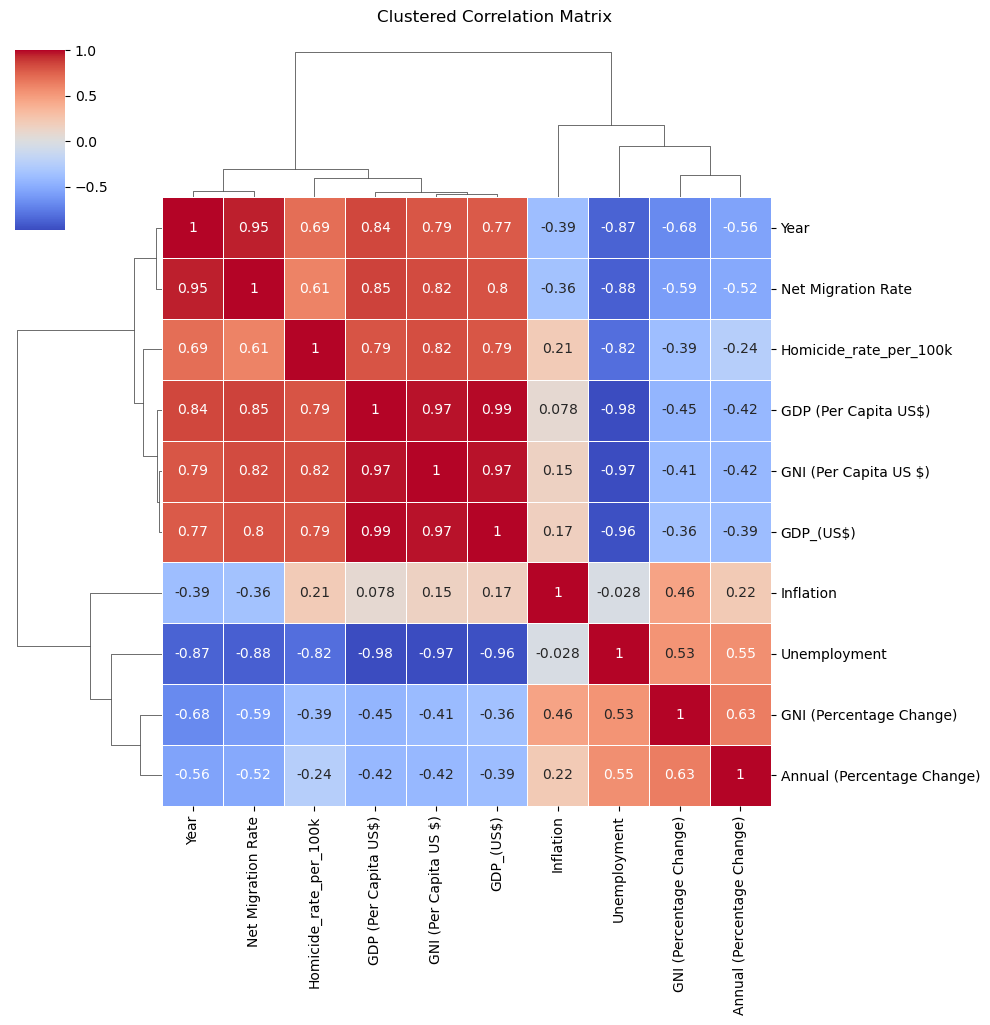

,Year,GDP (Per Capita US$),GNI (Per Capita US $),GNI (Percentage Change),Homicide_rate_per_100k,Annual (Percentage Change),Inflation,Unemployment,Net Migration Rate,GDP_(US$)
0,2000,7586.43,5140,10.54,9.01,25.24,3.555413,12.100,-4.353,8.154342e+09
1,2001,8123.99,5770,12.26,11.28,25.24,5.536653,10.880,-3.811,8.824849e+09
2,2002,8315.50,6420,11.27,12.70,12.62,4.150059,10.390,-3.270,9.008298e+09
3,2003,10505.01,7650,19.16,16.92,33.17,3.811106,10.480,-2.729,1.130546e+10
4,2004,12344.57,9190,20.13,19.10,12.90,3.721549,8.330,-2.750,1.328029e+10
5,2005,14865.93,10590,15.23,28.19,47.60,6.874535,7.950,-2.771,1.598239e+10
6,2006,17116.79,12560,18.60,26.94,-4.43,8.329604,6.270,-2.793,1.836936e+10
7,2007,20207.88,14170,12.82,28.23,4.79,7.894388,5.540,-2.814,2.164162e+10
8,2008,25836.24,16370,15.53,39.27,39.10,12.030345,4.630,-2.835,2.787159e+10
9,2009,17908.72,15270,-6.72,36.18,-7.87,6.978087,5.280,-2.387,1.917217e+10


In [582]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to include only rows where 'Year' is less than or equal to 2020
filtered_df = soc_info_07[soc_info_07['Year'] <= 2020]

# Select only numeric features
numeric_df = filtered_df.select_dtypes(include='number')
numeric_df = numeric_df.dropna(axis=1)

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Replace NaN or infinite values in the correlation matrix
corr_matrix = corr_matrix.fillna(0)  # Replace NaN with 0
corr_matrix = corr_matrix.replace([float('inf'), -float('inf')], 0)  # Replace infinite values with 0

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(10, 10), linewidths=0.5)
plt.suptitle("Clustered Correlation Matrix", y=1.02)
plt.show()
numeric_df

In [583]:
constituency_list = [
    'ARIMA', 'AROUCA/MALONEY', 'BARATARIA/SAN JUAN', 'CARONI CENTRAL', 'CARONI EAST',
    'CHAGUANAS EAST', 'CHAGUANAS WEST', 'COUVA NORTH', 'COUVA SOUTH', 'CUMUTO/MANZANILLA',
    "D'ABADIE/O'MEARA", 'DIEGO MARTIN CENTRAL', 'DIEGO MARTIN NORTH/EAST', 'DIEGO MARTIN WEST',
    'FYZABAD', 'LA BREA', 'LA HORQUETTA/TALPARO', 'LAVENTILLE EAST/MORVANT', 'LAVENTILLE WEST',
    'LOPINOT/BON AIR WEST', 'MAYARO', 'MORUGA/TABLELAND', 'NAPARIMA', 'OROPOUCHE EAST',
    'OROPOUCHE WEST', 'POINT FORTIN', 'POINTE-A-PIERRE', "PORT-OF-SPAIN NORTH/ST. ANN'S WEST",
    'PORT-OF-SPAIN SOUTH', 'PRINCES TOWN', 'SAN FERNANDO EAST', 'SAN FERNANDO WEST', 'SIPARIA',
    "ST. ANN'S EAST", 'ST. AUGUSTINE', 'ST. JOSEPH', 'TABAQUITE', 'TOBAGO EAST', 'TOBAGO WEST',
    'TOCO/SANGRE GRANDE', 'TUNAPUNA', 'TOTAL'
]

import numpy as np

# Repeat the constituency list
repeated_constituencies = constituency_list * 5  # because you said repeat 5 times

master_df['CONSTITUENCIES'] = repeated_constituencies

cols = ['CONSTITUENCIES'] + [col for col in master_df.columns if col != 'CONSTITUENCIES']
master_df = master_df[cols]
master_df

,CONSTITUENCIES,ELECTORATE,P.N.M._VOTES_%,U.N.C._VOTES_%,VOTER_TURNOUT,TOTAL_NUMBER_OF_VOTES_CAST,VALID_VOTES,Year,ELECTORAL_DISTRICT_ARIMA,ELECTORAL_DISTRICT_AROUCA/MALONEY,...,Inflation_1t,Inflation_1y,Unemployment_1t,Unemployment_1y,Net Migration Rate_1t,Net Migration Rate_1y,GDP (Per Capita US$)_1t,GDP (Per Capita US$)_1y,GDP_(US$)_1t,GDP_(US$)_1y
0,ARIMA,22845,0.643311,0.091528,0.589363,13464,13373,2007,True,False,...,0.797681,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934
1,AROUCA/MALONEY,23673,0.757795,0.093035,0.673679,15948,15908,2007,False,True,...,0.797681,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934
2,BARATARIA/SAN JUAN,24597,0.438868,0.327791,0.668821,16451,16358,2007,False,False,...,0.797681,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934
3,CARONI CENTRAL,22813,0.275943,0.458901,0.729409,16640,16594,2007,False,False,...,0.797681,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934
4,CARONI EAST,23554,0.233777,0.508234,0.698820,16460,16396,2007,False,False,...,0.797681,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,TOBAGO EAST,23685,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-1.961618,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661
206,TOBAGO WEST,28478,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-1.961618,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661
207,TOCO/SANGRE GRANDE,32498,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-1.961618,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661
208,TUNAPUNA,27512,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-1.961618,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661


## Model Training

### Multinomial Logistic Regression

In [584]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

df = master_df.copy()
df = df[df['Year'] == 2020]
constituencies = [
    "ELECTORAL_DISTRICT_ARIMA", "ELECTORAL_DISTRICT_AROUCA/MALONEY", "ELECTORAL_DISTRICT_BARATARIA/SAN JUAN", "ELECTORAL_DISTRICT_CARONI CENTRAL", "ELECTORAL_DISTRICT_CARONI EAST",
    "ELECTORAL_DISTRICT_CHAGUANAS EAST", "ELECTORAL_DISTRICT_CHAGUANAS WEST", "ELECTORAL_DISTRICT_COUVA NORTH", "ELECTORAL_DISTRICT_COUVA SOUTH", "ELECTORAL_DISTRICT_CUMUTO/MANZANILLA",
    "ELECTORAL_DISTRICT_D'ABADIE/O'MEARA", "ELECTORAL_DISTRICT_DIEGO MARTIN CENTRAL", "ELECTORAL_DISTRICT_DIEGO MARTIN NORTH/EAST", "ELECTORAL_DISTRICT_DIEGO MARTIN WEST",
    "ELECTORAL_DISTRICT_FYZABAD", "ELECTORAL_DISTRICT_LA BREA", "ELECTORAL_DISTRICT_LA HORQUETTA/TALPARO", "ELECTORAL_DISTRICT_LAVENTILLE EAST/MORVANT", "ELECTORAL_DISTRICT_LAVENTILLE WEST",
    "ELECTORAL_DISTRICT_LOPINOT/BON AIR WEST", "ELECTORAL_DISTRICT_MAYARO", "ELECTORAL_DISTRICT_MORUGA/TABLELAND", "ELECTORAL_DISTRICT_NAPARIMA", "ELECTORAL_DISTRICT_OROPOUCHE EAST",
    "ELECTORAL_DISTRICT_OROPOUCHE WEST", "ELECTORAL_DISTRICT_POINT FORTIN", "ELECTORAL_DISTRICT_POINTE-A-PIERRE", "ELECTORAL_DISTRICT_PORT-OF-SPAIN NORTH/ST. ANN'S WEST",
    "PORT-OF-SPAIN SOUTH", "PRINCES TOWN", "SAN FERNANDO EAST", "SAN FERNANDO WEST", "SIPARIA","ELECTORAL_DISTRICT_ST. ANN'S EAST", "ELECTORAL_DISTRICT_ST. AUGUSTINE", 
    "ELECTORAL_DISTRICT_ST. JOSEPH", "ELECTORAL_DISTRICT_TABAQUITE", "ELECTORAL_DISTRICT_TOBAGO EAST", "ELECTORAL_DISTRICT_TOBAGO WEST", "ELECTORAL_DISTRICT_TOCO/SANGRE GRANDE", 
    "ELECTORAL_DISTRICT_TUNAPUNA", "ELECTORAL_DISTRICT_TOTAL"
]

# Step 2: Get indexes where Year == 2024
df_2025 = master_df[master_df['Year'] != 2024]
indexes_2025 = df_2025.index.tolist()

# Step 3: Make key-value pairs
index_constituency_mapping = dict(zip(indexes_2025, constituencies))

# Add a column for the winning party
df['Winning_Party'] = df[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].idxmax(axis=1)

# Add a column for the margin of victory
df['Margin_of_Victory'] = df[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].apply(
    lambda row: row.max() - sorted(row)[-2], axis=1
)

# Define thresholds
safe_margin_threshold = 0.20    # Safe seat if margin of victory > 20%

# Identify safe seats
safe_seats = df[(df['Margin_of_Victory'] > safe_margin_threshold)]

safe_seat_columns = safe_seats.loc[:, safe_seats.columns.str.startswith('ELECTORAL_DISTRICT_')]
unique_safe_seats = safe_seat_columns.columns[(safe_seat_columns == True).any()].tolist()

# Identify marginal seats
marginal_seats = df[df['Margin_of_Victory'] < safe_margin_threshold]
marginal_seat_columns = marginal_seats.loc[:, marginal_seats.columns.str.startswith('ELECTORAL_DISTRICT_')]

unique_marginal_seats = marginal_seat_columns.columns[(marginal_seat_columns == True).any()].tolist()
seat_columns = marginal_seat_columns.columns[(marginal_seat_columns == True).any()]

# Create a dictionary where key = index, value = seat name
seat_index_mapping = {}

for seat in seat_columns:
    # Find the index (row) where the seat is True
    matching_indexes = marginal_seat_columns.index[marginal_seat_columns[seat] == True].tolist()
    for idx in matching_indexes:
        seat_index_mapping[idx] = seat

unique_safe_seats = [seat for seat in unique_safe_seats if seat not in unique_marginal_seats]
unique_marginal_seats.remove('ELECTORAL_DISTRICT_TOTAL')

print("Number of Safe Seats:", len(unique_safe_seats))
print("Number of Marginal Seats:", len(unique_marginal_seats))

seat_mapping_marginal = {}
seat_mapping_safe = {}

for index, constituency in index_constituency_mapping.items():
    if constituency in unique_safe_seats:
        seat_mapping_safe[index] = constituency
    elif constituency in unique_marginal_seats:
        seat_mapping_marginal[index] = constituency

seat_mapping_safe, seat_mapping_marginal

Number of Safe Seats: 29
Number of Marginal Seats: 12


({0: 'ELECTORAL_DISTRICT_ARIMA',
  1: 'ELECTORAL_DISTRICT_AROUCA/MALONEY',
  3: 'ELECTORAL_DISTRICT_CARONI CENTRAL',
  4: 'ELECTORAL_DISTRICT_CARONI EAST',
  6: 'ELECTORAL_DISTRICT_CHAGUANAS WEST',
  7: 'ELECTORAL_DISTRICT_COUVA NORTH',
  8: 'ELECTORAL_DISTRICT_COUVA SOUTH',
  10: "ELECTORAL_DISTRICT_D'ABADIE/O'MEARA",
  11: 'ELECTORAL_DISTRICT_DIEGO MARTIN CENTRAL',
  12: 'ELECTORAL_DISTRICT_DIEGO MARTIN NORTH/EAST',
  13: 'ELECTORAL_DISTRICT_DIEGO MARTIN WEST',
  14: 'ELECTORAL_DISTRICT_FYZABAD',
  15: 'ELECTORAL_DISTRICT_LA BREA',
  17: 'ELECTORAL_DISTRICT_LAVENTILLE EAST/MORVANT',
  18: 'ELECTORAL_DISTRICT_LAVENTILLE WEST',
  19: 'ELECTORAL_DISTRICT_LOPINOT/BON AIR WEST',
  22: 'ELECTORAL_DISTRICT_NAPARIMA',
  23: 'ELECTORAL_DISTRICT_OROPOUCHE EAST',
  24: 'ELECTORAL_DISTRICT_OROPOUCHE WEST',
  25: 'ELECTORAL_DISTRICT_POINT FORTIN',
  27: "ELECTORAL_DISTRICT_PORT-OF-SPAIN NORTH/ST. ANN'S WEST",
  33: "ELECTORAL_DISTRICT_ST. ANN'S EAST",
  34: 'ELECTORAL_DISTRICT_ST. AUGUSTINE',
  3

In [585]:
seat_mapping_safe_df = pd.DataFrame(list(seat_mapping_safe.items()), columns=['Index', 'Constituency_Safe'])
seat_mapping_marginal_df = pd.DataFrame(list(seat_mapping_marginal.items()), columns=['Index', 'Constituency_Marginal'])

seat_mapping_safe_df['Constituency_Safe'] = seat_mapping_safe_df['Constituency_Safe'].str.replace('ELECTORAL_DISTRICT_', '', regex=False)
seat_mapping_marginal_df['Constituency_Marginal'] = seat_mapping_marginal_df['Constituency_Marginal'].str.replace('ELECTORAL_DISTRICT_', '', regex=False)

# Join with master_df for safe seats
df_safe_seats = master_df.merge(seat_mapping_safe_df, left_on='CONSTITUENCIES', right_on='Constituency_Safe', how='left')
df_marginal_seats = master_df.merge(seat_mapping_marginal_df, left_on='CONSTITUENCIES', right_on='Constituency_Marginal', how='left')

df_safe_seats = df_safe_seats[df_safe_seats['Constituency_Safe'].notna()]
df_marginal_seats = df_marginal_seats[df_marginal_seats['Constituency_Marginal'].notna()]

df_safe_seats['Winning_Party'] = df_safe_seats[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].idxmax(axis=1)
df_marginal_seats['Winning_Party'] = df_marginal_seats[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].idxmax(axis=1)
# Show the resulting DataFrames for safe and marginal seats



In [586]:
leans_pnm = [
    "ARIMA", "AROUCA/MALONEY", "D'ABADIE/O'MEARA", "DIEGO MARTIN CENTRAL",
    "DIEGO MARTIN NORTH/EAST", "DIEGO MARTIN WEST", "LA BREA",
    "LAVENTILLE EAST/MORVANT", "LAVENTILLE WEST", "LOPINOT/BON AIR WEST",
    "POINT FORTIN", "PORT-OF-SPAIN NORTH/ST. ANN'S WEST", "PORT-OF-SPAIN SOUTH",
    "SAN FERNANDO EAST", "ST. ANN'S EAST", "TOBAGO WEST"
]

leans_unc = [
    "CARONI CENTRAL", "CARONI EAST", "CHAGUANAS WEST", "COUVA NORTH",
    "COUVA SOUTH", "FYZABAD", "NAPARIMA", "OROPOUCHE EAST",
    "OROPOUCHE WEST", "PRINCES TOWN", "SIPARIA", "ST. AUGUSTINE", "TABAQUITE"
]

battleground = [
    "BARATARIA/SAN JUAN", "CHAGUANAS EAST", "CUMUTO/MANZANILLA",
    "LA HORQUETTA/TALPARO", "MAYARO", "MORUGA/TABLELAND", "POINTE-A-PIERRE",
    "SAN FERNANDO WEST", "ST. JOSEPH", "TOBAGO EAST", "TOCO/SANGRE GRANDE",
    "TUNAPUNA"
]

# Make the mapping dictionary
safe_constituency_leaning = {}
marginal_constituency_leaning = {}
unknown_constituency_leaning = {}

for seat in master_df['CONSTITUENCIES']:
    if seat in leans_pnm:
        safe_constituency_leaning[seat] = 2  # Leans PNM
    elif seat in leans_unc:
        safe_constituency_leaning[seat] = 1  # Leans UNC
    elif seat in battleground:
        marginal_constituency_leaning[seat] = 3  # Battleground seat
    else:
        unknown_constituency_leaning[seat] = None  # Unknown

df_safe_seats['CONSTITUENCY_LEANING'] = df_safe_seats['CONSTITUENCIES'].map(safe_constituency_leaning)
df_marginal_seats['CONSTITUENCY_LEANING'] = df_marginal_seats['CONSTITUENCIES'].map(marginal_constituency_leaning)
master_df['CONSTITUENCY_LEANING'] = master_df['CONSTITUENCIES'].map(safe_constituency_leaning).fillna(
    master_df['CONSTITUENCIES'].map(marginal_constituency_leaning).fillna(
        master_df['CONSTITUENCIES'].map(unknown_constituency_leaning)
    )
)
master_df

/var/folders/sq/1kpcw4xx7jl5fm84wd3h_0s40000gn/T/ipykernel_15563/830625993.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  master_df['CONSTITUENCIES'].map(marginal_constituency_leaning).fillna(


,CONSTITUENCIES,ELECTORATE,P.N.M._VOTES_%,U.N.C._VOTES_%,VOTER_TURNOUT,TOTAL_NUMBER_OF_VOTES_CAST,VALID_VOTES,Year,ELECTORAL_DISTRICT_ARIMA,ELECTORAL_DISTRICT_AROUCA/MALONEY,...,Inflation_1y,Unemployment_1t,Unemployment_1y,Net Migration Rate_1t,Net Migration Rate_1y,GDP (Per Capita US$)_1t,GDP (Per Capita US$)_1y,GDP_(US$)_1t,GDP_(US$)_1y,CONSTITUENCY_LEANING
0,ARIMA,22845,0.643311,0.091528,0.589363,13464,13373,2007,True,False,...,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934,2.0
1,AROUCA/MALONEY,23673,0.757795,0.093035,0.673679,15948,15908,2007,False,True,...,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934,2.0
2,BARATARIA/SAN JUAN,24597,0.438868,0.327791,0.668821,16451,16358,2007,False,False,...,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934,3.0
3,CARONI CENTRAL,22813,0.275943,0.458901,0.729409,16640,16594,2007,False,False,...,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934,1.0
4,CARONI EAST,23554,0.233777,0.508234,0.698820,16460,16396,2007,False,False,...,-0.053664,-0.781211,-0.123782,-0.436258,0.007491,0.979712,0.166013,0.976068,0.163934,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,TOBAGO EAST,23685,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661,3.0
206,TOBAGO WEST,28478,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661,2.0
207,TOCO/SANGRE GRANDE,32498,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661,3.0
208,TUNAPUNA,27512,0.000000,0.000000,0.000000,0,0,2024,False,False,...,-2.225553,-0.883768,0.171975,-2.036499,-0.001759,1.101067,0.027614,1.238641,0.027661,3.0


In [587]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

features = [
            'CONSTITUENCY_LEANING','Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t',
            'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y','ELECTORATE'
            ] 

df_safe_seats_model = df_safe_seats[df_safe_seats['Year'] != 2024]
print(df_safe_seats_model['Winning_Party'].unique())
print(len(df_safe_seats_model))

# Prepare data for classification
X_safe = df_safe_seats_model[features]
y_safe = df_safe_seats_model['Winning_Party']

df_safe_seats_model

# Make it binary: 1 if PNM, 0 otherwise
y_safe_binary = (y_safe == 'P.N.M._VOTES_%').astype(int)

# Split the data
X_safe_train, X_safe_test, y_safe_train, y_safe_test = train_test_split(
    X_safe, y_safe_binary, 
    test_size=0.4, 
    random_state=42, 
    stratify=y_safe_binary
)

# Fit a classification model
clf = LogisticRegression(solver='saga', max_iter=1000)
clf.fit(X_safe_train, y_safe_train)

# Make predictions
y_safe_pred = clf.predict(X_safe_test)

# Evaluate the classification model
print("Classification Report for Safe Seats:\n")
print(classification_report(y_safe_test, y_safe_pred))

print("\nConfusion Matrix for Safe Seats:\n")
print(confusion_matrix(y_safe_test, y_safe_pred))
print(y_safe_binary.value_counts())

['P.N.M._VOTES_%' 'U.N.C._VOTES_%']
100
Classification Report for Safe Seats:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.51      0.95      0.67        21

    accuracy                           0.50        40
   macro avg       0.26      0.48      0.33        40
weighted avg       0.27      0.50      0.35        40


Confusion Matrix for Safe Seats:

[[ 0 19]
 [ 1 20]]
Winning_Party
1    52
0    48
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
features = ['CONSTITUENCY_LEANING','Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t',
            'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y',
            'ELECTORATE'
            ] 

df_safe_seats_model = df_safe_seats[df_safe_seats['Year'] != 2024]
print(len(df_safe_seats_model))

# Prepare data for classification
X_safe = df_safe_seats_model[features]
y_safe = df_safe_seats_model['Winning_Party']

# Make it binary: 1 if PNM, 0 otherwise
y_safe_binary = (y_safe == 'P.N.M._VOTES_%').astype(int)

# Split the data
X_safe_train, X_safe_test, y_safe_train, y_safe_test = train_test_split(
    X_safe, y_safe_binary, 
    test_size=0.4, 
    random_state=42, 
    stratify=y_safe_binary
)

# Fit a classification model
clf = LogisticRegression(solver='saga', max_iter=1000)
clf.fit(X_safe_train, y_safe_train)

# Make predictions
y_safe_pred = clf.predict(X_safe_test)

# Evaluate the classification model
print("Classification Report for Safe Seats:\n")
print(classification_report(y_safe_test, y_safe_pred))

print("\nConfusion Matrix for Safe Seats:\n")
print(confusion_matrix(y_safe_test, y_safe_pred))
print(y_safe_binary.value_counts())

100
Classification Report for Safe Seats:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.51      0.95      0.67        21

    accuracy                           0.50        40
   macro avg       0.26      0.48      0.33        40
weighted avg       0.27      0.50      0.35        40


Confusion Matrix for Safe Seats:

[[ 0 19]
 [ 1 20]]
Winning_Party
1    52
0    48
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [589]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers for Logistic Regression
    'max_iter': [100, 500, 1000],  # Number of iterations
    'class_weight': ['balanced', None]  # Handling class imbalance
}

# Initialize the logistic regression model
logreg = LogisticRegression(multi_class='ovr', max_iter=1000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_safe_train, y_safe_train)

# Get the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best model from grid search
best_logreg = grid_search.best_estimator_

# Make predictions using the best model
y_safe_pred = best_logreg.predict(X_safe_test)

# Evaluate the model with a classification report and confusion matrix
print("Classification Report for Safe Seats with Tuning:\n")
print(classification_report(y_safe_test, y_safe_pred))

print("\nConfusion Matrix for Safe Seats with Tuning:\n")
print(confusion_matrix(y_safe_test, y_safe_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_

Best hyperparameters found:  {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Classification Report for Safe Seats with Tuning:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Confusion Matrix for Safe Seats with Tuning:

[[19  0]
 [ 0 21]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [590]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the same feature columns as used in training
features = ['CONSTITUENCY_LEANING', 'Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate',
            'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y',
            'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t',
            'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y', 'ELECTORATE']

# Filter safe_seats to only include rows for 2025
safe_seats_2025_filtered = master_df[master_df['Year'] == 2024]
safe_seats_2025_filtered = safe_seats_2025_filtered[(safe_seats_2025_filtered['CONSTITUENCY_LEANING'] == 1) | (safe_seats_2025_filtered['CONSTITUENCY_LEANING'] == 2)]

# Show the filtered DataFrame
print(f"Rows after filtering for non-NaN 'Constituency_Leaning': {safe_seats_2025_filtered.shape[0]}")

# Select the same features for prediction
X_2025 = safe_seats_2025_filtered[features].copy()


# Scale using a scaler **fitted on X_safe**
scaler = StandardScaler()
X_safe_scaled = scaler.fit_transform(X_safe)        # fit on training data
X_2025_scaled = scaler.transform(X_2025)            # transform test (2025) data

# Use the best model from GridSearchCV or RandomizedSearchCV
best_model = grid_search.best_estimator_  # Use the model from GridSearchCV

# Predict class (0 or 1) using the tuned model
safe_seat_predictions = best_model.predict(X_2025_scaled)

# Optional: decode to party names
party_mapping = {1: 'P.N.M.', 0: 'U.N.C.'}
decoded_safe_predictions = [party_mapping[pred] for pred in safe_seat_predictions]

# Put predictions in a DataFrame
predictions_2025 = pd.DataFrame({
    'Constituency': safe_seats_2025_filtered['CONSTITUENCIES'],  # assuming index is constituency name
    'Predicted_Winning_Party': decoded_safe_predictions
})

# View the predictions
print(y_safe_train.value_counts())
print("Model Coefficients:\n", clf.coef_)
y_safe_train_pred = clf.predict(X_safe_train)
print("Training Accuracy: ", accuracy_score(y_safe_train, y_safe_train_pred))

# predictions_2025
predictions_2025


Rows after filtering for non-NaN 'Constituency_Leaning': 29
Winning_Party
1    31
0    29
Name: count, dtype: int64
Model Coefficients:
 [[ 2.70288613e-05 -1.71889739e-04 -2.37805802e-05 -7.41112201e-05
  -3.10383276e-05  4.42177298e-06 -9.44778782e-06 -2.71494602e-06
   4.48274225e-07  1.37182714e-06 -3.54663485e-06  5.31398629e-07
  -9.43674020e-08 -7.76437155e-07 -4.30185619e-07 -8.40858948e-07
   1.57646379e-05]]
Training Accuracy:  0.5166666666666667


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Constituency,Predicted_Winning_Party
168,ARIMA,P.N.M.
169,AROUCA/MALONEY,P.N.M.
171,CARONI CENTRAL,U.N.C.
172,CARONI EAST,U.N.C.
174,CHAGUANAS WEST,U.N.C.
175,COUVA NORTH,U.N.C.
176,COUVA SOUTH,U.N.C.
178,D'ABADIE/O'MEARA,P.N.M.
179,DIEGO MARTIN CENTRAL,P.N.M.
180,DIEGO MARTIN NORTH/EAST,P.N.M.


### Multinomial Linear Regression

##### PNM

In [662]:
# 1. Features
df_marginal_seats_model = df_marginal_seats[df_marginal_seats['Year'] != 2024]
X_marginal = df_marginal_seats_model[features]

# 2. Target (both UNC and PNM)
y_marginal = df_marginal_seats_model[['U.N.C._VOTES_%', 'P.N.M._VOTES_%']]

# 3. Train-test split
X_marginal_train, X_marginal_test, y_marginal_train, y_marginal_test = train_test_split(
    X_marginal, y_marginal, test_size=0.3, random_state=42)

# 4. Train the model
reg = LinearRegression()
reg.fit(X_marginal_train, y_marginal_train)

# 5. Predict for test set
y_marginal_pred_all = reg.predict(X_marginal)

# Flatten the arrays for actual and predicted values (for the entire dataset)
actual_unc_all = y_marginal['U.N.C._VOTES_%'].values
predicted_unc_all = y_marginal_pred_all[:, 0]  # UNC predictions (first column)

actual_pnm_all = y_marginal['P.N.M._VOTES_%'].values
predicted_pnm_all = y_marginal_pred_all[:, 1]  # PNM predictions (second column)

# 6. Evaluate the performance (MSE and R^2)
mse_unc_all = mean_squared_error(actual_unc_all, predicted_unc_all)
r2_unc_all = r2_score(actual_unc_all, predicted_unc_all)

mse_pnm_all = mean_squared_error(actual_pnm_all, predicted_pnm_all)
r2_pnm_all = r2_score(actual_pnm_all, predicted_pnm_all)

print(f"Mean Squared Error (UNC) on entire dataset: {mse_unc_all}")
print(f"R-squared (UNC) on entire dataset: {r2_unc_all}")

print(f"Mean Squared Error (PNM) on entire dataset: {mse_pnm_all}")
print(f"R-squared (PNM) on entire dataset: {r2_pnm_all}")

# 6. Create a DataFrame with the results
marginal_results_df_all = pd.DataFrame({
    'Constituency': df_marginal_seats_model['CONSTITUENCIES'],
    'Actual_UNC_Vote_Share': actual_unc_all,
    'Predicted_UNC_Vote_Share': predicted_unc_all,
    'Actual_PNM_Vote_Share': actual_pnm_all,
    'Predicted_PNM_Vote_Share': predicted_pnm_all
})

print("\nMarginal Seats Regression Results:\n")
marginal_results_df_all

Mean Squared Error (UNC) on entire dataset: 0.007711591734742355
R-squared (UNC) on entire dataset: 0.5214111033012772
Mean Squared Error (PNM) on entire dataset: 0.00486079893652534
R-squared (PNM) on entire dataset: 0.33492666450547426

Marginal Seats Regression Results:



,Constituency,Actual_UNC_Vote_Share,Predicted_UNC_Vote_Share,Actual_PNM_Vote_Share,Predicted_PNM_Vote_Share
2,BARATARIA/SAN JUAN,0.327791,0.320678,0.438868,0.473389
5,CHAGUANAS EAST,0.315294,0.286237,0.426686,0.480408
9,CUMUTO/MANZANILLA,0.416860,0.322281,0.403055,0.473062
16,LA HORQUETTA/TALPARO,0.242454,0.290997,0.577614,0.479438
20,MAYARO,0.460859,0.333186,0.435390,0.470840
21,MORUGA/TABLELAND,0.428425,0.331630,0.492378,0.471157
26,POINTE-A-PIERRE,0.356550,0.318656,0.432365,0.473801
35,ST. JOSEPH,0.289352,0.325890,0.467527,0.472327
37,TOBAGO EAST,0.243427,0.238588,0.366332,0.490119
39,TOCO/SANGRE GRANDE,0.232281,0.353720,0.574512,0.466655


In [676]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline with feature scaling (StandardScaler) and Ridge regression
model = Ridge()

# Define the expanded parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.1, 1, 10, 100],  # Regularization strength for Ridge
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model using the training data
grid_search.fit(X_marginal_train, y_marginal_train)

# Get the best parameters and the best model
print(f"Best parameters found: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_marginal_pred_tuned = best_model.predict(X_marginal)

# Flatten the arrays for actual and predicted values (separating UNC and PNM predictions)
actual_unc = y_marginal['U.N.C._VOTES_%'].values
predicted_unc = y_marginal_pred_tuned[:, 0]  # UNC predictions (first column)

actual_pnm = y_marginal['P.N.M._VOTES_%'].values
predicted_pnm = y_marginal_pred_tuned[:, 1]  # PNM predictions (second column)

# Compute the MSE and R² for both UNC and PNM
mse_unc = mean_squared_error(actual_unc, predicted_unc)
r2_unc = r2_score(actual_unc, predicted_unc)

mse_pnm = mean_squared_error(actual_pnm, predicted_pnm)
r2_pnm = r2_score(actual_pnm, predicted_pnm)

print(f"Mean Squared Error (MSE) for UNC predictions: {mse_unc}")
print(f"R-squared (R²) for UNC predictions: {r2_unc}")

print(f"Mean Squared Error (MSE) for PNM predictions: {mse_pnm}")
print(f"R-squared (R²) for PNM predictions: {r2_pnm}")

# Create a DataFrame to compare actual and predicted values for both parties
marginal_results_df_tuned = pd.DataFrame({
    'Constituency': df_marginal_seats_model['CONSTITUENCIES'],
    'Actual_UNC_Vote_Share': actual_unc,
    'Predicted_UNC_Vote_Share': predicted_unc,
    'Actual_PNM_Vote_Share': actual_pnm,
    'Predicted_PNM_Vote_Share': predicted_pnm
})

# Display the results
print("\nTuned Model Marginal Seats Regression Results:\n")
marginal_results_df_tuned

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ...........................................alpha=10; total time=   0.0s
[CV] END ...........................................alpha=10; total time=   0.0s
[CV] END ...........................................alpha=10; total time=   0.0s
[CV] END ...................

,Constituency,Actual_UNC_Vote_Share,Predicted_UNC_Vote_Share,Actual_PNM_Vote_Share,Predicted_PNM_Vote_Share
2,BARATARIA/SAN JUAN,0.327791,0.359032,0.438868,0.469968
5,CHAGUANAS EAST,0.315294,0.321701,0.426686,0.476549
9,CUMUTO/MANZANILLA,0.416860,0.360769,0.403055,0.469662
16,LA HORQUETTA/TALPARO,0.242454,0.326861,0.577614,0.475639
20,MAYARO,0.460859,0.372589,0.435390,0.467578
21,MORUGA/TABLELAND,0.428425,0.370903,0.492378,0.467876
26,POINTE-A-PIERRE,0.356550,0.356841,0.432365,0.470355
35,ST. JOSEPH,0.289352,0.364681,0.467527,0.468972
37,TOBAGO EAST,0.243427,0.270055,0.366332,0.485653
39,TOCO/SANGRE GRANDE,0.232281,0.394846,0.574512,0.463655


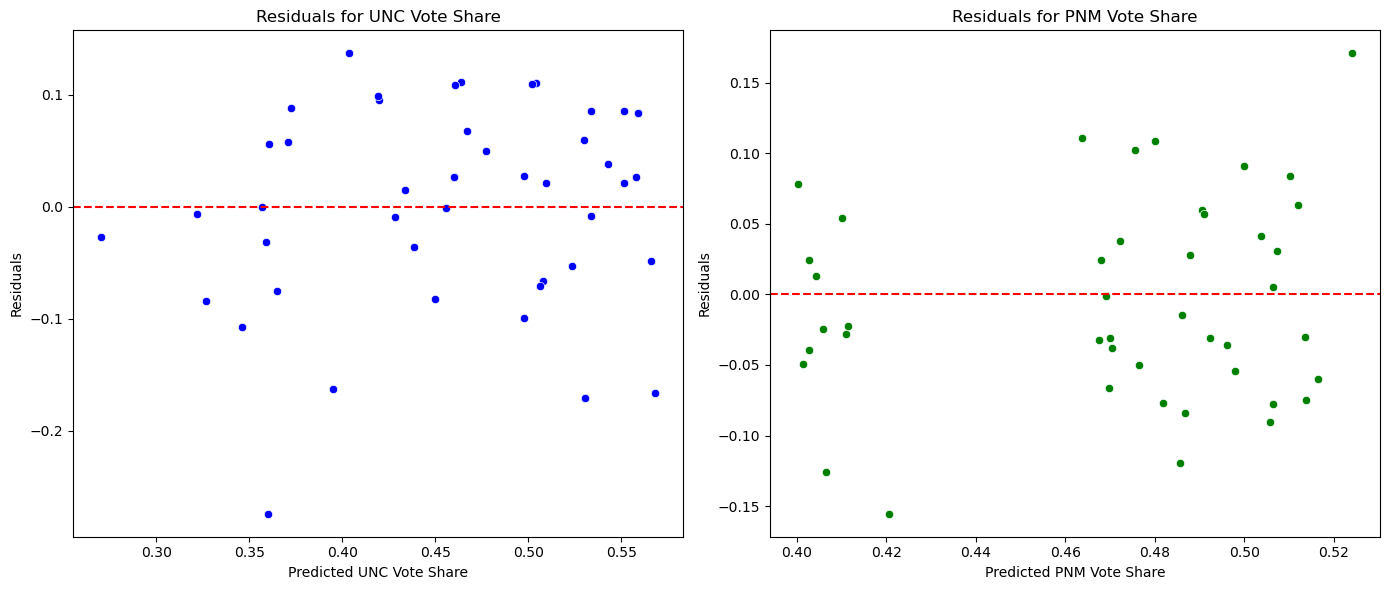

Mean Squared Error (MSE) for UNC: 0.008044406924334202
Mean Squared Error (MSE) for PNM: 0.004956012056113893
R-squared (R²) for UNC: 0.5007562683631488
R-squared (R²) for PNM: 0.3218992367400987


In [669]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Mean Squared Error for both UNC and PNM
mse_unc = mean_squared_error(actual_unc, predicted_unc)
mse_pnm = mean_squared_error(actual_pnm, predicted_pnm)

# 2. R-squared (R²) for both UNC and PNM
r2_unc = r2_score(actual_unc, predicted_unc)
r2_pnm = r2_score(actual_pnm, predicted_pnm)

# 3. Residuals for analysis
residuals_unc = actual_unc - predicted_unc
residuals_pnm = actual_pnm - predicted_pnm

# Plotting
plt.figure(figsize=(14, 6))

# 4. Residual plot for UNC
plt.subplot(1, 2, 1)
sns.scatterplot(x=predicted_unc, y=residuals_unc, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for UNC Vote Share')
plt.xlabel('Predicted UNC Vote Share')
plt.ylabel('Residuals')

# 5. Residual plot for PNM
plt.subplot(1, 2, 2)
sns.scatterplot(x=predicted_pnm, y=residuals_pnm, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for PNM Vote Share')
plt.xlabel('Predicted PNM Vote Share')
plt.ylabel('Residuals')

# Show plots
plt.tight_layout()
plt.show()

# Print the evaluation metrics
print(f"Mean Squared Error (MSE) for UNC: {mse_unc}")
print(f"Mean Squared Error (MSE) for PNM: {mse_pnm}")
print(f"R-squared (R²) for UNC: {r2_unc}")
print(f"R-squared (R²) for PNM: {r2_pnm}")

In [677]:
# 1. Determine the predicted winner based on the predicted vote shares
marginal_results_df_tuned['Predicted_Winner'] = np.where(
    marginal_results_df_tuned['Predicted_UNC_Vote_Share'] > marginal_results_df_tuned['Predicted_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

# 2. Determine the actual winner based on the actual vote shares
marginal_results_df_tuned['Actual_Winner'] = np.where(
    marginal_results_df_tuned['Actual_UNC_Vote_Share'] > marginal_results_df_tuned['Actual_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

# 3. Print the predicted and actual winners for each constituency
print(marginal_results_df_tuned[['Constituency', 'Actual_Winner', 'Predicted_Winner']])

             Constituency Actual_Winner Predicted_Winner
2      BARATARIA/SAN JUAN           PNM              PNM
5          CHAGUANAS EAST           PNM              PNM
9       CUMUTO/MANZANILLA           UNC              PNM
16   LA HORQUETTA/TALPARO           PNM              PNM
20                 MAYARO           UNC              PNM
21       MORUGA/TABLELAND           PNM              PNM
26        POINTE-A-PIERRE           PNM              PNM
35             ST. JOSEPH           PNM              PNM
37            TOBAGO EAST           PNM              PNM
39     TOCO/SANGRE GRANDE           PNM              PNM
40               TUNAPUNA           PNM              PNM
44     BARATARIA/SAN JUAN           UNC              UNC
47         CHAGUANAS EAST           UNC              UNC
51      CUMUTO/MANZANILLA           UNC              UNC
58   LA HORQUETTA/TALPARO           UNC              UNC
62                 MAYARO           UNC              UNC
63       MORUGA/TABLELAND      

In [675]:
# 1. Determine the predicted winner based on the predicted vote shares
marginal_results_df_all['Predicted_Winner'] = np.where(
    marginal_results_df_all['Predicted_UNC_Vote_Share'] > marginal_results_df_all['Predicted_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

# 2. Determine the actual winner based on the actual vote shares
marginal_results_df_all['Actual_Winner'] = np.where(
    marginal_results_df_all['Actual_UNC_Vote_Share'] > marginal_results_df_all['Actual_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

# 3. Print the predicted and actual winners for each constituency
print(marginal_results_df_all[['Constituency', 'Actual_Winner', 'Predicted_Winner']])

             Constituency Actual_Winner Predicted_Winner
2      BARATARIA/SAN JUAN           PNM              PNM
5          CHAGUANAS EAST           PNM              PNM
9       CUMUTO/MANZANILLA           UNC              PNM
16   LA HORQUETTA/TALPARO           PNM              PNM
20                 MAYARO           UNC              PNM
21       MORUGA/TABLELAND           PNM              PNM
26        POINTE-A-PIERRE           PNM              PNM
35             ST. JOSEPH           PNM              PNM
37            TOBAGO EAST           PNM              PNM
39     TOCO/SANGRE GRANDE           PNM              PNM
40               TUNAPUNA           PNM              PNM
44     BARATARIA/SAN JUAN           UNC              UNC
47         CHAGUANAS EAST           UNC              UNC
51      CUMUTO/MANZANILLA           UNC              UNC
58   LA HORQUETTA/TALPARO           UNC              UNC
62                 MAYARO           UNC              UNC
63       MORUGA/TABLELAND      

In [679]:
normal_model_accuracy = (marginal_results_df_all['Predicted_Winner'] == marginal_results_df_all['Actual_Winner']).mean()
print(f"Normal Model Accuracy: {normal_model_accuracy:.2%}")

tuned_model_accuracy = (marginal_results_df_tuned['Predicted_Winner'] == marginal_results_df_tuned['Actual_Winner']).mean()
print(f"Tuned Model Accuracy: {tuned_model_accuracy:.2%}")

Normal Model Accuracy: 68.18%
Tuned Model Accuracy: 70.45%


In [ ]:
# If Predicted PNM > Predicted UNC, PNM wins
marginal_2025_results_df = pd.merge(marginal_2025_results_df_unc_recalibrated, marginal_2025_results_df_pnm, on='Constituency')
marginal_2025_results_df
marginal_2025_results_df['Predicted_Winner'] = np.where(
    marginal_2025_results_df['Predicted_Vote_Share'] > marginal_2025_results_df['Predicted_Vote_Share_Recalibrated'], 
    'PNM', 
    'UNC'
)

print(marginal_2025_results_df[['Constituency', 'Predicted_Winner']])

In [592]:
# Prepare data for regression

df_marginal_seats_model = df_marginal_seats[df_marginal_seats['Year'] != 2024]
df_marginal_seats_model = df_marginal_seats_model[df_marginal_seats_model['CONSTITUENCY_LEANING'] == 3]

X_marginal = df_marginal_seats_model[features]
y_marginal = df_marginal_seats_model['P.N.M._VOTES_%']

# Split the data
X_marginal_train, X_marginal_test, y_marginal_train, y_marginal_test = train_test_split(X_marginal, y_marginal, test_size=0.3, random_state=42)

# Fit a regression model
reg = LinearRegression()
reg.fit(X_marginal_train, y_marginal_train)

# Make predictions
y_marginal_pred = reg.predict(X_marginal_test)

# Evaluate the regression model
print("Mean Squared Error for Marginal Seats: ", mean_squared_error(y_marginal_test, y_marginal_pred))
print("R-squared for Marginal Seats: ", r2_score(y_marginal_test, y_marginal_pred))

# Create a DataFrame to compare actual and predicted values
marginal_results_df = pd.DataFrame({
    'Actual_Vote_Share': y_marginal_test,
    'Predicted_Vote_Share': y_marginal_pred
})

print("\nMarginal Seats Regression Results:\n")
print(marginal_results_df)

Mean Squared Error for Marginal Seats:  0.005853678401255135
R-squared for Marginal Seats:  0.3005569308845861

Marginal Seats Regression Results:

     Actual_Vote_Share  Predicted_Vote_Share
146           0.402618              0.490051
93            0.415575              0.511353
100           0.575021              0.518077
142           0.550374              0.494191
131           0.461692              0.496109
161           0.515542              0.491262
20            0.435390              0.470840
47            0.382670              0.401248
37            0.366332              0.490119
16            0.577614              0.479438
26            0.432365              0.473801
105           0.511452              0.512110
123           0.590449              0.505021
79            0.265261              0.411485


In [593]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the model
ridge = Ridge()

# Define the parameter grid for tuning
param_grid = {
    'alpha': [0.1, 1, 10, 100],  # Regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_marginal_train, y_marginal_train)

# Get the best hyperparameters from the grid search
print(f"Best hyperparameters: {grid_search.best_params_}")

# Get the best model from the grid search
best_ridge = grid_search.best_estimator_

# Make predictions using the best model
y_marginal_pred = best_ridge.predict(X_marginal_test)

# Evaluate the tuned model
print("Mean Squared Error for Marginal Seats (Tuned): ", mean_squared_error(y_marginal_test, y_marginal_pred))
print("R-squared for Marginal Seats (Tuned): ", r2_score(y_marginal_test, y_marginal_pred))

# Create a DataFrame to compare actual and predicted values
marginal_results_df = pd.DataFrame({
    'Actual_Vote_Share': y_marginal_test,
    'Predicted_Vote_Share': y_marginal_pred
})

print("\nMarginal Seats Regression Results (Tuned):\n")
print(marginal_results_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best hyperparameters: {'alpha': 100}
Mean Squared Error for Marginal Seats (Tuned):  0.006054543909594375
R-squared for Marginal Seats (Tuned):  0.2765559561125348

Marginal Seats Regression Results (Tuned):

     Actual_Vote_Share  Predicted_Vote_Share
146           0.402618              0.486710
93            0.415575              0.505739
100           0.575021              0.512043
142           0.550374              0.490592
131           0.461692              0.492390
161           0.515542              0.487845
20            0.435390              0.467578
47            0.382670              0.411064
37            0.366332              0.485653
16            0.577614              0.475639
26            0.432365              0.470355
105           0.511452              0.506449
123           0.590449              0.499803
79            0.265261              0.420662


In [594]:
# Filter the data for 2025
df_marginal_seats_2025 = master_df[(master_df['Year'] == 2024) & (master_df['CONSTITUENCIES'] != 'TOTAL') & (master_df['CONSTITUENCY_LEANING'] == 3)]

# Ensure we only use the same features that were used in training
X_marginal_2025 = df_marginal_seats_2025[features]

# Predict the vote share for the 2025 marginal seats
y_marginal_2025_pred = reg.predict(X_marginal_2025)

# Create a DataFrame to compare actual and predicted values for 2025
marginal_2025_results_df_pnm = pd.DataFrame({
    'Constituency': df_marginal_seats_2025['CONSTITUENCIES'],
    'Actual_Vote_Share': df_marginal_seats_2025['P.N.M._VOTES_%'],  # Actual values, if available
    'Predicted_Vote_Share': y_marginal_2025_pred
})

# Show the results
print("\n2025 PNM Marginal Seats Prediction Results:\n")
print(marginal_2025_results_df_pnm)


2025 PNM Marginal Seats Prediction Results:

             Constituency  Actual_Vote_Share  Predicted_Vote_Share
170    BARATARIA/SAN JUAN                0.0              0.523013
173        CHAGUANAS EAST                0.0              0.516444
177     CUMUTO/MANZANILLA                0.0              0.505021
184  LA HORQUETTA/TALPARO                0.0              0.514019
188                MAYARO                0.0              0.510484
189      MORUGA/TABLELAND                0.0              0.509850
194       POINTE-A-PIERRE                0.0              0.523609
199     SAN FERNANDO WEST                0.0              0.525657
203            ST. JOSEPH                0.0              0.512643
205           TOBAGO EAST                0.0              0.528077
207    TOCO/SANGRE GRANDE                0.0              0.500135
208              TUNAPUNA                0.0              0.515943


##### UNC

In [595]:
# Prepare data for regression
df_marginal_seats_model = df_marginal_seats[df_marginal_seats['Year'] != 2024]
X_marginal = df_marginal_seats_model[features]
y_marginal = df_marginal_seats_model['U.N.C._VOTES_%']

# Split the data
X_marginal_train, X_marginal_test, y_marginal_train, y_marginal_test = train_test_split(X_marginal, y_marginal, test_size=0.3, random_state=42)

# Fit a regression model
reg = LinearRegression()
reg.fit(X_marginal_train, y_marginal_train)

# Make predictions
y_marginal_pred = reg.predict(X_marginal_test)

# Evaluate the regression model
print("Mean Squared Error for Marginal Seats: ", mean_squared_error(y_marginal_test, y_marginal_pred))
print("R-squared for Marginal Seats: ", r2_score(y_marginal_test, y_marginal_pred))

# Create a DataFrame to compare actual and predicted values
marginal_results_df = pd.DataFrame({
    'Actual_Vote_Share': y_marginal_test,
    'Predicted_Vote_Share': y_marginal_pred
})

print("\nMarginal Seats Regression Results:\n")
print(marginal_results_df)

Mean Squared Error for Marginal Seats:  0.005293865675595401
R-squared for Marginal Seats:  0.5745181395127124

Marginal Seats Regression Results:

     Actual_Vote_Share  Predicted_Vote_Share
146           0.589975              0.516152
93            0.575092              0.479225
100           0.419410              0.446230
142           0.441410              0.495835
131           0.525305              0.486424
161           0.470844              0.510209
20            0.460859              0.333186
47            0.615109              0.531904
37            0.243427              0.238588
16            0.242454              0.290997
26            0.356550              0.318656
105           0.486229              0.475507
123           0.398436              0.510291
79            0.367369              0.481673


In [596]:
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import GridSearchCV

# # Define the model
# ridge = Ridge()

# # Define the parameter grid for tuning
# param_grid = {
#     'alpha': [0.1, 1, 10, 100],  # Regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# # Fit GridSearchCV to the data
# grid_search.fit(X_marginal_train, y_marginal_train)

# # Get the best hyperparameters from the grid search
# print(f"Best hyperparameters: {grid_search.best_params_}")

# # Get the best model from the grid search
# best_ridge = grid_search.best_estimator_

# # Make predictions using the best model
# y_marginal_pred = best_ridge.predict(X_marginal_test)

# # Evaluate the tuned model
# print("Mean Squared Error for Marginal Seats (Tuned): ", mean_squared_error(y_marginal_test, y_marginal_pred))
# print("R-squared for Marginal Seats (Tuned): ", r2_score(y_marginal_test, y_marginal_pred))

# # Create a DataFrame to compare actual and predicted values
# marginal_results_df = pd.DataFrame({
#     'Actual_Vote_Share': y_marginal_test,
#     'Predicted_Vote_Share': y_marginal_pred
# })

# print("\nMarginal Seats Regression Results (Tuned):\n")
# print(marginal_results_df)

In [597]:
# Filter the data for 2025
df_marginal_seats_2025 = master_df[(master_df['Year'] == 2024) & (master_df['CONSTITUENCIES'] != 'TOTAL') & (master_df['CONSTITUENCY_LEANING'] == 3)]

# Ensure we only use the same features that were used in training
X_marginal_2025 = df_marginal_seats_2025[features]

# Predict the vote share for the 2025 marginal seats
y_marginal_2025_pred = reg.predict(X_marginal_2025)

# Create a DataFrame to compare actual and predicted values for 2025
marginal_2025_results_df_unc = pd.DataFrame({
    'Constituency': df_marginal_seats_2025['CONSTITUENCIES'],
    'Actual_Vote_Share': df_marginal_seats_2025['U.N.C._VOTES_%'],  # Actual values, if available
    'Predicted_Vote_Share': y_marginal_2025_pred
})

# Show the results
print("\n2025 UNC Marginal Seats Prediction Results:\n")
print(marginal_2025_results_df_unc)


2025 UNC Marginal Seats Prediction Results:

             Constituency  Actual_Vote_Share  Predicted_Vote_Share
170    BARATARIA/SAN JUAN                0.0              0.765120
173        CHAGUANAS EAST                0.0              0.797353
177     CUMUTO/MANZANILLA                0.0              0.853402
184  LA HORQUETTA/TALPARO                0.0              0.809254
188                MAYARO                0.0              0.826599
189      MORUGA/TABLELAND                0.0              0.829710
194       POINTE-A-PIERRE                0.0              0.762196
199     SAN FERNANDO WEST                0.0              0.752146
203            ST. JOSEPH                0.0              0.816005
205           TOBAGO EAST                0.0              0.740277
207    TOCO/SANGRE GRANDE                0.0              0.877375
208              TUNAPUNA                0.0              0.799811


In [598]:
import numpy as np

def recalibrate_predictions(predictions, k=5, center=0.5):
    """
    Apply a sigmoid recalibration to prevent extreme vote share predictions.
    
    Args:
        predictions (array-like): Raw model predictions.
        k (float): Steepness of the sigmoid. Higher = steeper.
        center (float): Center point around which to squash.
        
    Returns:
        array-like: Adjusted predictions.
    """
    return 1 / (1 + np.exp(-k * (predictions - center)))

y_marginal_2025_pred_recalibrated = recalibrate_predictions(y_marginal_2025_pred, k=5, center=0.5)

marginal_2025_results_df_unc_recalibrated = pd.DataFrame({
    'Constituency': df_marginal_seats_2025['CONSTITUENCIES'],
    'Actual_Vote_Share': df_marginal_seats_2025['U.N.C._VOTES_%'],
    'Predicted_Vote_Share_Recalibrated': y_marginal_2025_pred_recalibrated
})

marginal_2025_results_df_unc_recalibrated

,Constituency,Actual_Vote_Share,Predicted_Vote_Share_Recalibrated
170,BARATARIA/SAN JUAN,0.0,0.790112
173,CHAGUANAS EAST,0.0,0.815592
177,CUMUTO/MANZANILLA,0.0,0.854086
184,LA HORQUETTA/TALPARO,0.0,0.824374
188,MAYARO,0.0,0.836579
189,MORUGA/TABLELAND,0.0,0.838695
194,POINTE-A-PIERRE,0.0,0.787677
199,SAN FERNANDO WEST,0.0,0.779152
203,ST. JOSEPH,0.0,0.829208
205,TOBAGO EAST,0.0,0.768771


In [599]:
# If Predicted PNM > Predicted UNC, PNM wins
marginal_2025_results_df = pd.merge(marginal_2025_results_df_unc_recalibrated, marginal_2025_results_df_pnm, on='Constituency')
marginal_2025_results_df
marginal_2025_results_df['Predicted_Winner'] = np.where(
    marginal_2025_results_df['Predicted_Vote_Share'] > marginal_2025_results_df['Predicted_Vote_Share_Recalibrated'], 
    'PNM', 
    'UNC'
)

print(marginal_2025_results_df[['Constituency', 'Predicted_Winner']])

            Constituency Predicted_Winner
0     BARATARIA/SAN JUAN              UNC
1         CHAGUANAS EAST              UNC
2      CUMUTO/MANZANILLA              UNC
3   LA HORQUETTA/TALPARO              UNC
4                 MAYARO              UNC
5       MORUGA/TABLELAND              UNC
6        POINTE-A-PIERRE              UNC
7      SAN FERNANDO WEST              UNC
8             ST. JOSEPH              UNC
9            TOBAGO EAST              UNC
10    TOCO/SANGRE GRANDE              UNC
11              TUNAPUNA              UNC


In [600]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, confusion_matrix
# import joblib

# # === 1. Define features and target ===
# features = [
#     'Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate',
#     'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y',
#     'Net Migration Rate_1t', 'Net Migration Rate_1y',
#     'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y'
# ]

# df_safe_seats_model = df_safe_seats[df_safe_seats['Year'] != 2024]

# X_safe = df_safe_seats_model[features]
# y_safe = df_safe_seats_model['Winning_Party']

# # Encode target
# y_safe_encoded = y_safe.astype('category').cat.codes

# # === 2. Split data ===
# X_safe_train, X_safe_test, y_safe_train, y_safe_test = train_test_split(
#     X_safe, y_safe_encoded, test_size=0.4, random_state=42, stratify=y_safe_encoded
# )

# # (Optional) Scale features — Random Forests don't strictly need scaling, but if you want consistency:
# # scaler = StandardScaler()
# # X_safe_train = scaler.fit_transform(X_safe_train)
# # X_safe_test = scaler.transform(X_safe_test)

# # === 3. Define Random Forest Model and GridSearch ===
# rf = RandomForestClassifier(random_state=42)

# param_grid_rf = {
#     'n_estimators': [50, 100, 200, 300, 500],
#     'max_depth': [None, 5, 10, 20, 30],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 5, 10],
#     'max_features': ['sqrt', 'log2', 0.8, 0.5],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# grid_search_rf = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid_rf,
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# # === 4. Train model ===
# grid_search_rf.fit(X_safe_train, y_safe_train)

# print("Best hyperparameters found: ", grid_search_rf.best_params_)

# # === 5. Evaluate ===
# best_rf = grid_search_rf.best_estimator_

# y_safe_pred_rf = best_rf.predict(X_safe_test)

# print("\nClassification Report for Safe Seats (Random Forest):\n")
# print(classification_report(y_safe_test, y_safe_pred_rf))

# print("\nConfusion Matrix for Safe Seats (Random Forest):\n")
# print(confusion_matrix(y_safe_test, y_safe_pred_rf))

# # === 6. Save model if needed ===
# joblib.dump(best_rf, "random_forest_safe_seats_model.pkl")

In [601]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()


# features = ['Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate', 'Inflation_1t', 'Inflation_1y', 
#             'Unemployment_1t','Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t',
#             'GDP_(US$)_1y', 'VOTER_TURNOUT', 'VALID_VOTES'] 

# # print(features)

# X = master_df[features]
# print(X.columns.tolist())
# X_scaled = scaler.fit_transform(X)

# if 'VOTER_TURNOUT' not in socioeconomic_df.columns:
#     socioeconomic_df['VOTER_TURNOUT'] = 0
# if 'VALID_VOTES' not in socioeconomic_df.columns:
#     socioeconomic_df['VALID_VOTES'] = 0

# # Select features for 2025
# X_2025 = socioeconomic_df[socioeconomic_df['Year'] == 2025][features]



# # Ensure `X_2024` has the same features as the training data
# X_2025_aligned = pd.DataFrame(columns=features, index=X_2025.index)   # Create an empty DataFrame with training features
# X_2025_aligned.update(X_2025)  # Update with the values from `X_2025`
# X_2025_aligned.fillna(0, inplace=True)  # Fill missing features with 0


# # Reorder columns to match the training data
# X_2025_aligned = X_2025_aligned[features]

# # Scale the input data if scaling was applied during training
# X_2025_scaled = scaler.transform(X_2025_aligned)

# print(X_2025_scaled)

# # Predict the winning party for 2024
# winning_party_2025 = clf.predict(X_2025_scaled)

# # Decode the prediction if the target variable was encoded
# party_mapping = {0: 'P.N.M.', 1: 'U.N.C.'}  # Adjust based on your encoding
# decoded_predictions = [party_mapping[pred] for pred in winning_party_2025]

# # Count the number of seats won by each party
# seat_breakdown = pd.Series(decoded_predictions).value_counts()

# # Print the breakdown of seats
# print("Breakdown of Seats Won in 2025:")
# print(seat_breakdown)

### Support Vector Machine

##### Marginal Seats 

In [602]:
# from sklearn import metrics
# from sklearn.svm import SVR
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler


# df = safe_seats.copy()

# target = 'P.N.M._VOTES_%'  # P.N.M. vote share as the target

# X = df.drop(['P.N.M._VOTES_%', 'U.N.C._VOTES_%','Winning_Party', 'Margin_of_Victory'], axis=1)
# y = df[target]


# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# svr = SVR(kernel='linear') 
# svr.fit(X_train, y_train)

# y_pred = svr.predict(X_test)

# #mse for eval
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")

# r2 = r2_score(y_test, y_pred)
# print(f"R^2 score: {r2}")

# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())

# print(df[features].corrwith(df['P.N.M._VOTES_%']))
# print(df[features].corrwith(df['U.N.C._VOTES_%']))


Graphical plot of SVM results

In [603]:
# import matplotlib.pyplot as plt

# plt.scatter(y_test, y_pred)
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.title("SVM Predictions")
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # ideal predictions line
# plt.show()

### Support Vector Machine 

##### Safe Seats

In [604]:
# df = master_df.copy()

# target = 'U.N.C._VOTES_%'  # P.N.M. vote share as the target

# X = df.drop(['U.N.C._VOTES_%', 'P.N.M._VOTES_%'], axis=1)
# y = df[target]


# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # initialize and train the Support Vector Regression model
# svr = SVR(kernel='linear')  # change kernel as needed
# svr.fit(X_train, y_train)

# y_pred = svr.predict(X_test)

# #mse for eval
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")

# r2 = r2_score(y_test, y_pred)
# print(f"R² score: {r2}")

# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())

Graphical plot of SVM results

In [605]:

# plt.scatter(y_test, y_pred)
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.title("SVM Predictions")
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # ideal predictions line
# plt.show()

### Decision Tree Regression and Classifiers w/o marginal

##### Decision Tree Regressor w/o marginal

##### PNM

In [606]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn import metrics

# decisions = master_df.copy()

# feat_cols = ['Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 
#             'Unemployment_1t','Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t',
#             'GDP_(US$)_1y', 'VOTER_TURNOUT', 'VALID_VOTES'] # All socioeconomic
# # feat_cols = ['Year', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'GDP_(US$)_1t',
# #             'GDP_(US$)_1y'] # National Economic trends
# # feat_cols = ['Inflation', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t',
# #             'GDP_(US$)_1y'] # Household Purchasing Power

# target = 'P.N.M._VOTES_%'  # P.N.M. vote share as the target

# X = decisions[feat_cols]
# y = decisions[target]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # # training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=25)

# # model test
# regressor = DecisionTreeRegressor()

# regressor = regressor.fit(X_train, y_train)

# y_pred = regressor.predict(X_test)

# # performance tests 

# mse = metrics.mean_squared_error(y_test, y_pred)

# print("R^2 score:", metrics.r2_score(y_test, y_pred))

# print("Mean Squared Error:", mse)

# print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))

# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())

##### UNC

In [607]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn import metrics

# decisions = master_df.copy()

# feat_cols = ['Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 
#             'Unemployment_1t','Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t',
#             'GDP_(US$)_1y', 'VOTER_TURNOUT', 'VALID_VOTES'] # All socioeconomic

# target = 'U.N.C._VOTES_%'  # P.N.M. vote share as the target

# X = decisions[feat_cols]
# y = decisions[target]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # # training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=25)

# # model test
# regressor = DecisionTreeRegressor()

# regressor = regressor.fit(X_train, y_train)

# y_pred = regressor.predict(X_test)

# # performance tests 

# mse = metrics.mean_squared_error(y_test, y_pred)

# print("R^2 score:", metrics.r2_score(y_test, y_pred))

# print("Mean Squared Error:", mse)

# print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))

# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())

### Decision Tree Classisfier w/o marginal

##### PNM

In [608]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import KBinsDiscretizer

# decisions = master_df.copy()

# ['Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 
#             'Unemployment_1t','Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t',
#             'GDP_(US$)_1y', 'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES'] # All socioeconomic

# # feat_cols = ['Year', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'GDP_(US$)_1t',
# #             'GDP_(US$)_1y'] # National Economic trends
# # feat_cols = ['Inflation', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y']  # Household Purchasing Power

# target = 'P.N.M._VOTES_%'  # P.N.M. vote share as the target

# X = decisions[feat_cols] 
# y = decisions[target]  

# # discretize the target variable into bins
# discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')  # adjust `n_bins` as needed
# y_binned = discretizer.fit_transform(y.values.reshape(-1, 1)).ravel()

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binned, test_size=0.1, random_state=25)

# # model test
# clf = DecisionTreeClassifier()

# clf = clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# # performance metrics 
# accuracy = metrics.accuracy_score(y_test, y_pred)

# print("Accuracy:", accuracy)

# print("Classification Report:")
# print(metrics.classification_report(y_test, y_pred))

# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())

##### UNC

In [609]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import KBinsDiscretizer

# decisions = master_df.copy()

# ['Year', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Net Migration Rate', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 
#             'Unemployment_1t','Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t',
#             'GDP_(US$)_1y', 'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES'] # All socioeconomic

# # feat_cols = ['Year', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'GDP_(US$)_1t',
# #             'GDP_(US$)_1y'] # National Economic trends
# # feat_cols = ['Inflation', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y']  # Household Purchasing Power

# target = 'U.N.C._VOTES_%'  # P.N.M. vote share as the target

# X = decisions[feat_cols] 
# y = decisions[target]  

# # discretize the target variable into bins
# discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')  # adjust `n_bins` as needed
# y_binned = discretizer.fit_transform(y.values.reshape(-1, 1)).ravel()

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binned, test_size=0.1, random_state=25)

# # model test
# clf = DecisionTreeClassifier()

# clf = clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# # performance metrics 
# accuracy = metrics.accuracy_score(y_test, y_pred)

# print("Accuracy:", accuracy)

# print("Classification Report:")
# print(metrics.classification_report(y_test, y_pred))

# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())

### Decision Tree Regressor and Classifier based on marginal Seats

In [610]:
# df = master_df.copy()

# df['Winning_Party'] = df[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].idxmax(axis=1)

# # adding a column for aa the margin of victory
# df['Margin_of_Victory'] =  df[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].apply(
#     lambda row: row.max() -  sorted(row)[-2], axis=1
# )

# # thresholds 
# safe_vote_share_threshold = 0.60 # Safe seat if vote share > 60%
# safe_margin_threshold = 0.20 # Safe seat if margin of victory > 20%
# marginal_margin_threshold = 0.10 # Margnal seat if margin of victory < 10%

# # identify safe seats
# safe_seats = df[
#     (df['Margin_of_Victory'] > safe_margin_threshold) |
#     (df[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].max(axis=1) > safe_vote_share_threshold)
# ]

# # marginal seats 
# marginal_seats = df[df['Margin_of_Victory'] < marginal_margin_threshold]

# print("Number of Safe Seats: ", len(safe_seats))
# print("Number of Marginal Seats: ", len(marginal_seats))

# df.to_csv(r"csvs/master_df_with_seat_analysis.csv", index=False)


### Decision Tree Regressor w/ marginal

In [611]:
# X_safe = safe_seats[feat_cols]
# y_safe = safe_seats['P.N.M._VOTES_%']
# z_safe = safe_seats['U.N.C._VOTES_%']

# scaler = StandardScaler()
# X_safe_scaled = scaler.fit_transform(X_safe)

# # training set and test set
# X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_safe_scaled, y_safe, test_size=0.2, random_state=42)
# X_u_train, X_u_test, y_u_train, y_u_test = train_test_split(X_safe_scaled, z_safe, test_size=0.2, random_state=42)

# # model train 
# # P.N.M.
# p_regressor = DecisionTreeRegressor(random_state=42)
# p_regressor.fit(X_p_train, y_p_train)

# # U.N.C.
# p_regressor = DecisionTreeRegressor(random_state=42)
# p_regressor.fit(X_u_train, y_u_train)

# y_p_pred = regressor.predict(X_p_test)
# y_u_pred = regressor.predict(X_u_test)

# # performance tests
# mse_p = mean_squared_error(y_p_test, y_p_pred)
# mse_u = mean_squared_error(y_u_test, y_u_pred)

# r2_p = r2_score(y_p_test, y_p_pred)
# r2_u = r2_score(y_u_test, y_u_pred)

# print(f"Mean Squared Error PNM: {mse_p}  UNC: {mse_u}")
# print(f"R² Score PNM: {r2_p} UNC: {r2_u}")

# # actual vs predicted values
# print("PNM")
# results = pd.DataFrame({'Actual': y_p_test, 'Predicted': y_p_pred})
# print(results.head())

# print("UNC")
# results_u = pd.DataFrame({'Actual': y_u_test, 'Predicted': y_u_pred})
# print(results_u.head())

### Decision Tree Classisfier w/ marginal

In [612]:
# from sklearn.tree import DecisionTreeClassifier
# # Model Evaluation
# from sklearn.metrics import accuracy_score, classification_report

# X_safe = safe_seats[feat_cols]
# y_safe = safe_seats['Winning_Party']

# y_safe_encoded = y_safe.astype('category').cat.codes

# scaler = StandardScaler()
# X_safe_scaled = scaler.fit_transform(X_safe)

# # Split dataset into training set and test set
# X_safe_train, X_safe_test, y_safe_train, y_safe_test = train_test_split(X_safe_scaled, y_safe_encoded, test_size=0.2, random_state=25)

# classifier = DecisionTreeClassifier(random_state=25)
# classifier = classifier.fit(X_safe_train, y_safe_train)

# # Predict response for test dataset
# y_safe_pred = classifier.predict(X_safe_test)


# accuracy = accuracy_score(y_safe_test, y_safe_pred)
# print(f"Accuracy: {accuracy}")

# print("Classification Report:")
# print(classification_report(y_safe_test, y_safe_pred))

# results = pd.DataFrame({'Actual': y_safe_test, 'Predicted': y_safe_pred})
# print(results.head())

### Visualization

In [613]:
# # taken from datacamp
# # Install the required package
# # %pip install pydotplus

# from sklearn.tree import export_graphviz
# from six import StringIO  
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = feat_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('elections.png')
# Image(graph.create_png())

### BACKUP

In [614]:
# X_safe = safe_seats[feat_cols]
# y_safe = safe_seats['P.N.M._VOTES_%']

# scaler = StandardScaler()
# X_safe_scaled = scaler.fit_transform(X_safe)

# # training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_safe_scaled, y_safe, test_size=0.2, random_state=42)

# # model train 
# regressor = DecisionTreeRegressor(random_state=42)
# regressor.fit(X_train, y_train)

# y_pred = regressor.predict(X_test)

# # performance tests
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R² Score: {r2}")

# # actual vs predicted values
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())

### MLP Regression

In [615]:
# from sklearn.neural_network import MLPRegressor

# df = safe_seats.copy()

# X = df[features]  
# y = df['P.N.M._VOTES_%']

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'hidden_layer_sizes': [(100,), (100, 30), (50, 50), (150, 75, 30)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'sgd'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'adaptive']
# }

# mlp = MLPRegressor(max_iter=1000, random_state=42)

# grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

In [616]:
# mlp = MLPRegressor(hidden_layer_sizes=(100,30), 
#                    activation='relu',  
#                    solver='adam',      
#                    alpha=0.0001,       
#                    max_iter=1000,
#                    random_state=42,
#                    learning_rate= 'constant')


# mlp.fit(X_train, y_train)

# y_pred = mlp.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"MSE: {mse}")
# print(f"R² Score: {r2}")

# print("Actual vs Predicted:")
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results.head())